# MLLB Deep Learning Report </font></br></div>



Course: Machine Learning Lab





---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_data ="/content/drive/My Drive/dataset_ready_2D_filtered"

In [ ]:
import os, math, random
import numpy as np
from glob import glob
from tqdm import tqdm
import pydicom
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from monai.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import cv2
from collections import Counter
from scipy.ndimage import zoom
import imageio

In [ ]:
import os

print(f"Listing contents of path_data: {path_data}")
if os.path.exists(path_data):
    print(os.listdir(path_data))
else:
    print(f"Directory does not exist: {path_data}")



Listing contents of path_data: /content/drive/My Drive/dataset_ready_2D_filtered
['T1DUAL_OutPhase', 'T1DUAL_InPhase', 'T2SPIR']


# Data Set Definition

### Dataset Creation


In [ ]:
#For one modality

class DICOMSliceDataset(Dataset):
    def __init__(self, patients, base_path, modality="T2SPIR", transform=None):
        """
        patients: list of patient IDs
        base_path: root dataset path
        modality: T2SPIR / T1DUAL_InPhase / etc.
        transform: optional spatial transforms (MONAI / torchvision)
        """
        self.slice_paths = []
        self.mask_paths = []
        self.transform = transform

        for patient in patients:
            img_folder = os.path.join(base_path, modality, "images", patient)
            mask_folder = os.path.join(base_path, modality, "masks", patient)

            dicoms = sorted([
                f for f in os.listdir(img_folder)
                if f.lower().endswith(".dcm")
            ])

            masks = sorted([
                f for f in os.listdir(mask_folder)
                if f.lower().endswith((".png", ".jpg"))
            ])

            # Safety check (VERY important)
            assert len(dicoms) == len(masks), (
                f"Mismatch for patient {patient}: "
                f"{len(dicoms)} images vs {len(masks)} masks"
            )

            for dcm_file, mask_file in zip(dicoms, masks):
                self.slice_paths.append(os.path.join(img_folder, dcm_file))
                self.mask_paths.append(os.path.join(mask_folder, mask_file))

    def __len__(self):
        return len(self.slice_paths)

    def __getitem__(self, idx):
        # Load image
        ds = pydicom.dcmread(self.slice_paths[idx])
        img = ds.pixel_array.astype(np.float32)  # (H, W)

        # Min-max normalisation par slice
        mn, mx = img.min(), img.max()
        if mx > mn:
            img = (img - mn) / (mx - mn)
        else:
            img = img * 0.0

        img = img[None, :, :]


        # Load mask
        mask = np.array(
            Image.open(self.mask_paths[idx]),
            dtype=np.int64
        )  # (H, W) with class indices

        # Convert to tensors
        img = torch.from_numpy(img)       # float32
        mask = torch.from_numpy(mask)     # int64 (LONG)

        # Apply transforms
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return {
            "image": img,   # (1, H, W), float32
            "mask": mask    # (H, W), int64
        }



In [ ]:
# Function to define a paired data set
class PairedDICOMSliceDataset(Dataset):
    def __init__(self, patients, base_path, modalities=("T1DUAL_InPhase", "T1DUAL_OutPhase"), transform=None):
        self.slice_paths = []  # list of tuples (path_mod1, path_mod2)
        self.mask_paths  = []
        self.transform = transform

        for patient in patients:
            folders = [os.path.join(base_path, mod, "images", patient) for mod in modalities]
            mask_folder = os.path.join(base_path, modalities[0], "masks", patient)  # mask shared

            dicoms = [sorted(os.listdir(f)) for f in folders]  # list of lists
            masks  = sorted(os.listdir(mask_folder))

            # Safety check
            assert all(len(d) == len(masks) for d in dicoms), f"Mismatch for patient {patient}"

            for i in range(len(masks)):
                self.slice_paths.append(tuple([os.path.join(folders[j], dicoms[j][i]) for j in range(len(modalities))]))
                self.mask_paths.append(os.path.join(mask_folder, masks[i]))

    def __len__(self):
        return len(self.mask_paths)

    def __getitem__(self, idx):
        imgs = []
        for path in self.slice_paths[idx]:
            ds = pydicom.dcmread(path)
            img = ds.pixel_array.astype(np.float32)
            mn, mx = img.min(), img.max()
            if mx > mn:
                img = (img - mn) / (mx - mn)
            img = torch.from_numpy(img).unsqueeze(0)  # (1,H,W)
            imgs.append(img)

        # Stack modalities as channels
        img = torch.cat(imgs, dim=0)  # (num_modalities, H, W)

        mask = np.array(Image.open(self.mask_paths[idx]), dtype=np.int64)
        mask = torch.from_numpy(mask)  # (H,W)

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return {"image": img, "mask": mask}


### Patient Split


In [ ]:
patients= ['1', '10', '13', '15', '19', '2', '20', '21', '22', '3', '31', '32', '33', '34', '36', '37', '38', '39', '5', '8']
#split into test and train sets
train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)

random.seed(42)  # for reproducibility

val_fraction = 0.15  # 15% of train patients

n_val = math.ceil(len(train_patients) * val_fraction)
val_patients = train_patients[:n_val]        # first n_val patients
train_patients = train_patients[n_val:]      # rest remain in train

print("Train patients:", train_patients)
print("Validation patients:", val_patients)
print("Test patients:", test_patients)

Train patients: ['15', '5', '38', '34', '13', '3', '8', '19', '33', '21', '31', '36', '20']
Validation patients: ['22', '2', '32']
Test patients: ['1', '39', '37', '10']


### Defining the Dataset for Each Scenario

In [ ]:
# Data set for one modality (eg. T2SPIR)
train_ds = DICOMSliceDataset(train_patients, base_path=path_data, modality="T2SPIR")
val_ds   = DICOMSliceDataset(val_patients, base_path=path_data, modality="T2SPIR")

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=1, shuffle=False)

test_ds = DICOMSliceDataset(test_patients, base_path=path_data, modality="T2SPIR", transform=None)
test_loader = torch.utils.data.DataLoader( test_ds, batch_size=1, shuffle=False)

In [ ]:
# Data set for a paired modality (T1Dual inphase and outphase)
#train_ds = PairedDICOMSliceDataset(train_patients, base_path=path_data)
#val_ds   = PairedDICOMSliceDataset(val_patients, base_path=path_data)
#test_ds  = PairedDICOMSliceDataset(test_patients, base_path=path_data)

#train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
#val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)
#test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

In [ ]:
# Data Set with all modalities
from torch.utils.data import ConcatDataset

#modalities = ["T2SPIR","T1DUAL_InPhase", "T1DUAL_OutPhase"]

#train_set = [
    #DICOMSliceDataset(train_patients, path_data, modality=m)
   #for m in modalities
#]

#val_set = [
    #DICOMSliceDataset(val_patients, path_data, modality=m)
    #for m in modalities
#]

#test_set = [
    #DICOMSliceDataset(test_patients, path_data, modality=m)
    #for m in modalities
#]

#train_ds = ConcatDataset(train_set)
#val_ds   = ConcatDataset(val_set)
#test_ds  = ConcatDataset(test_set)

#train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
#val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)
#test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)


### Sanity Check of Dataset

In [ ]:
def sanity_check_one_batch(loader):
    batch = next(iter(loader))
    x = batch["image"]
    y = batch["mask"]
    print("image:", x.shape, x.dtype, "min/max:", float(x.min()), float(x.max()))
    print("mask :", y.shape, y.dtype, "unique:", torch.unique(y)[:20])

sanity_check_one_batch(train_loader)


image: torch.Size([1, 1, 256, 256]) torch.float32 min/max: 0.0 1.0
mask : torch.Size([1, 256, 256]) torch.int64 unique: tensor([0, 3])


# Model, Training, and Evaluation Functions


$\textbf{Model parameters}$

In [ ]:
# Hyperparams
NUM_CLASSES = 5               # background + 4 organs
BATCH_SIZE = 1
MAX_EPOCHS = 20
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)


Device: cuda


### Loss function

In [ ]:
def soft_dice_loss(logits, targets, num_classes=5, eps=1e-6):
    """
    logits: (B,C,H,W)
    targets: (B,H,W) int64 labels
    """
    probs = F.softmax(logits, dim=1)  # (B,C,H,W)

    # one-hot des targets
    targets_oh = F.one_hot(targets, num_classes=num_classes)  # (B,H,W,C)

    targets_oh = targets_oh.permute(0, 3, 1, 2).float()       # (B,C,H,W)

    dims = (0, 2, 3)
    intersection = torch.sum(probs * targets_oh, dims)
    cardinality  = torch.sum(probs + targets_oh, dims)

    dice = (2. * intersection + eps) / (cardinality + eps)    # (C,)

    dice = dice[1:]   # ignore background

    loss = 1 - dice.mean()

    return loss

In [ ]:
ce_loss = nn.CrossEntropyLoss()

def total_loss(logits, targets):
    return ce_loss(logits, targets) + soft_dice_loss(logits, targets, num_classes=NUM_CLASSES)

DICE score per class function

In [ ]:
@torch.no_grad()
def dice_per_class(pred, target, num_classes=5, eps=1e-6):
    """
    pred: (B,H,W) int64
    target: (B,H,W) int64
    retourne dice (C,) avec dice pour chaque classe
    """
    dices = []
    for c in range(num_classes):
        pred_c = (pred == c).float()
        targ_c = (target == c).float()
        inter = (pred_c * targ_c).sum()
        denom = pred_c.sum() + targ_c.sum()
        dice = (2*inter + eps) / (denom + eps)
        dices.append(dice.item())
    return np.array(dices)

### Training Function for one epoch

In [ ]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running = 0.0

    for batch in loader:
        x = batch["image"].to(DEVICE)   # (B,1,256,256)
        y = batch["mask"].to(DEVICE)    # (B,256,256)

        optimizer.zero_grad()
        logits = model(x)
        loss = total_loss(logits, y)
        loss.backward()
        optimizer.step()

        running += loss.item()

    return running / max(1, len(loader))

### Validation Function

In [ ]:
@torch.no_grad()
def validate(model, loader):
    model.eval()
    running = 0.0
    dice_sum = np.zeros(NUM_CLASSES, dtype=np.float64)
    n = 0

    for batch in loader:
        x = batch["image"].to(DEVICE)
        y = batch["mask"].to(DEVICE)

        logits = model(x)
        loss = total_loss(logits, y)
        running += loss.item()

        pred = torch.argmax(logits, dim=1)  # (B,H,W)
        dices = dice_per_class(pred.cpu(), y.cpu(), NUM_CLASSES)
        dice_sum += dices
        n += 1

    avg_loss = running / max(1, len(loader))
    avg_dice = dice_sum / max(1, n)
    return avg_loss, avg_dice

### Prediction Visualization Functions


In [ ]:
@torch.no_grad()
def show_prediction(model, loader, class_names=None):
    model.eval()
    batch = next(iter(loader))
    x = batch["image"].to(DEVICE)
    y = batch["mask"].cpu().numpy()[0]          # (H,W)

    logits = model(x)
    pred = torch.argmax(logits, dim=1).cpu().numpy()[0]

    img = x.cpu().numpy()[0, 0]                # (H,W)

    plt.figure()
    plt.title("Image (MRI slice)")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    plt.figure()
    plt.title("Ground Truth Mask")
    plt.imshow(y, vmin=0, vmax=NUM_CLASSES-1)
    plt.axis("off")
    plt.show()

    plt.figure()
    plt.title("Prediction")
    plt.imshow(pred, vmin=0, vmax=NUM_CLASSES-1)
    plt.axis("off")
    plt.show()

In [ ]:
@torch.no_grad()
def show_test_predictions(model, test_loader, num_samples=10):
    model.eval()

    fig, axes = plt.subplots(
        num_samples, 3,
        figsize=(12, 3 * num_samples)
    )

    shown = 0

    for batch in test_loader:
        if shown >= num_samples:
            break

        # Load data
        x = batch["image"].to(DEVICE)        # (1,1,H,W)
        y = batch["mask"].cpu().numpy()[0]   # (H,W)

        # Prediction
        logits = model(x)
        pred = torch.argmax(logits, dim=1).cpu().numpy()[0]

        img = x.cpu().numpy()[0, 0]           # (H,W)

        # Plot row
        axes[shown, 0].imshow(img, cmap="gray")
        axes[shown, 0].set_title("MRI")
        axes[shown, 0].axis("off")

        axes[shown, 1].imshow(y, vmin=0, vmax=NUM_CLASSES-1)
        axes[shown, 1].set_title("Ground Truth")
        axes[shown, 1].axis("off")

        axes[shown, 2].imshow(pred, vmin=0, vmax=NUM_CLASSES-1)
        axes[shown, 2].set_title("Prediction")
        axes[shown, 2].axis("off")

        shown += 1

    plt.tight_layout()
    plt.show()


In [ ]:
@torch.no_grad()
def save_test_predictions(
    model,
    test_loader,
    save_dir="test_results",
    max_samples=None
):
    """
    Sauvegarde une image par sample du test :
    MRI | Ground Truth | Prediction
    """

    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    sample_idx = 0

    for batch in test_loader:
        if max_samples is not None and sample_idx >= max_samples:
            break

        # Load data
        x = batch["image"].to(DEVICE)               # (1,1,H,W)
        y = batch["mask"].cpu().numpy()[0]          # (H,W)

        # Prediction
        logits = model(x)
        pred = torch.argmax(logits, dim=1)
        pred = pred.cpu().numpy()[0]

        # Prepare image
        img = x.cpu().numpy()[0, 0]                 # (H,W)

        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(img, cmap="gray")
        axes[0].set_title("MRI")
        axes[0].axis("off")

        axes[1].imshow(y, vmin=0, vmax=NUM_CLASSES-1)
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        axes[2].imshow(pred, vmin=0, vmax=NUM_CLASSES-1)
        axes[2].set_title("Prediction")
        axes[2].axis("off")

        plt.tight_layout()

        # Save
        save_path = os.path.join(save_dir, f"sample_{sample_idx:04d}.png")
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close(fig)

        sample_idx += 1

    print(f"Saved {sample_idx} test samples to '{save_dir}'")

### Dice Evaluation Functions


In [ ]:
def dice_score(pred, gt, num_classes, eps=1e-6):
    """
    pred, gt : (H,W) numpy arrays
    return : dice per classe (array of length num_classes)
    """
    dices = np.zeros(num_classes, dtype=np.float64)

    for c in range(num_classes):
        pred_c = (pred == c)
        gt_c   = (gt == c)

        intersection = np.logical_and(pred_c, gt_c).sum()
        denom = pred_c.sum() + gt_c.sum()

        if denom == 0:
            dices[c] = np.nan
        else:
            dices[c] = (2.0 * intersection) / (denom + eps)

    return dices

In [ ]:
@torch.no_grad()
def evaluate_model(model, test_loader, num_classes):
    model.eval()

    all_dices = []

    for batch in test_loader:
        x = batch["image"].to(DEVICE)
        gt = batch["mask"].cpu().numpy()[0]

        logits = model(x)
        pred = torch.argmax(logits, dim=1).cpu().numpy()[0]

        dices = dice_score(pred, gt, num_classes)
        all_dices.append(dices)

    all_dices = np.array(all_dices)  # (N_samples, num_classes)
    return all_dices

# Models Training and Evaluation

## Monai Unet

In [ ]:
model = UNet(
    spatial_dims=2,      # 2D
    in_channels=1,       # grayscale
    out_channels=5,      # number of classes
    channels=(16,32,64,128),
    strides=(2,2,2),
    num_res_units=2
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_function = total_loss


In this section, we train the model using different imaging modality configurations to compare their impact on segmentation performance. These experiments are conducted using the MONAI U-Net as a reference model, allowing us to select the most effective modality setup before applying it to the remaining architectures.

Epoch 01/20 | train_loss=2.2436 | val_loss=1.9430 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.947 0.38  0.025 0.104 0.07 ]


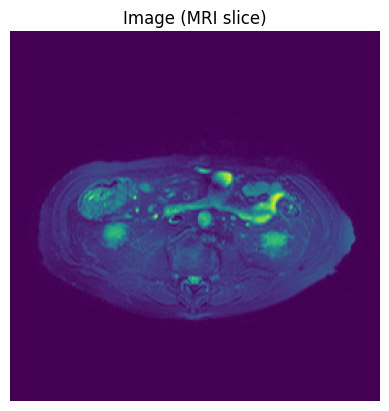

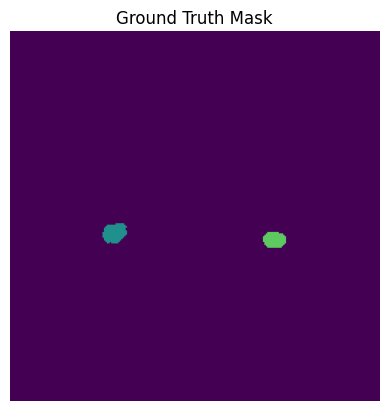

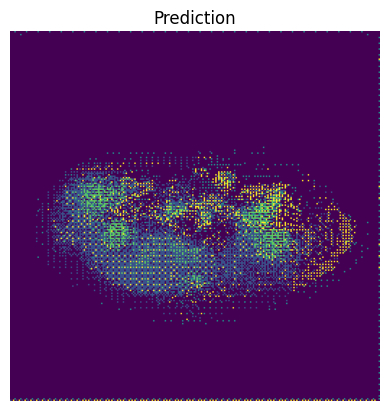

Epoch 02/20 | train_loss=1.7079 | val_loss=1.4787 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.968 0.525 0.08  0.186 0.052]
Epoch 03/20 | train_loss=1.3344 | val_loss=1.2018 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.982 0.599 0.106 0.284 0.038]
Epoch 04/20 | train_loss=1.1358 | val_loss=1.0643 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.981 0.603 0.162 0.367 0.023]
Epoch 05/20 | train_loss=1.0200 | val_loss=0.9723 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.981 0.606 0.213 0.382 0.072]
Epoch 06/20 | train_loss=0.9367 | val_loss=0.9063 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.983 0.645 0.243 0.401 0.09 ]
Epoch 07/20 | train_loss=0.8741 | val_loss=0.8518 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.985 0.653 0.306 0.444 0.21 ]
Epoch 08/20 | train_loss=0.8207 | val_loss=0.8078 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.986 0.664 0.292 0.562 0.325]
Epoch 09/20 | train_loss=0.7767 | val_loss=0.7702 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.987 0.675 0.59  0.578 0.363]
Epoch 10/20 | train_loss=0.7239 | val_loss=0.7229 | Dice (bg,liv

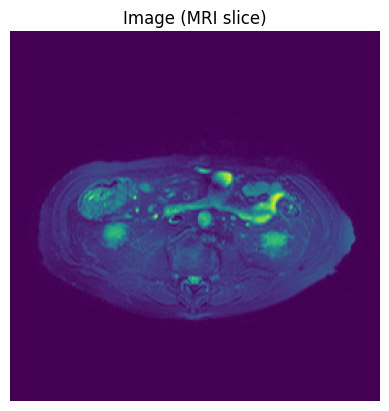

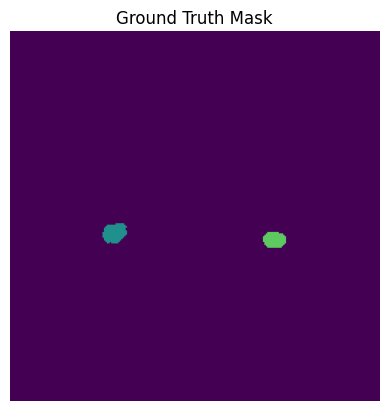

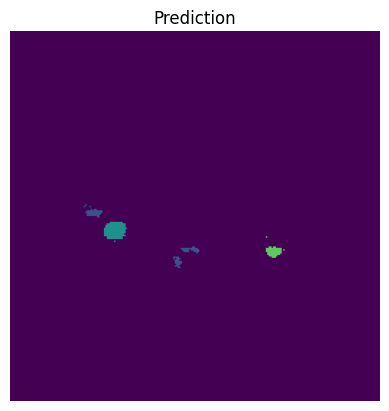

Saved model.


In [ ]:
# Training Loop

train_losses = []
val_losses = []
val_dices = []

for epoch in range(1, MAX_EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer)
    va_loss, va_dice = validate(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_dices.append(va_dice)

    # Dice organes (sans background)
    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"Dice (bg,liver,Rkid,Lkid,spleen)={np.round(va_dice, 3)}")

    # sanity visuel de temps en temps
    if epoch in [1, MAX_EPOCHS]:
        show_prediction(model, val_loader)

# Option: sauvegarde
torch.save(model.state_dict(), "unet_monai_T2SPIR.pth")
print("Saved model.")

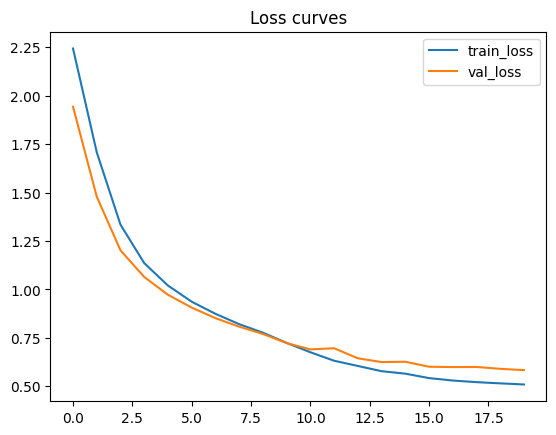

In [ ]:
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.title("Loss curves")
plt.show()

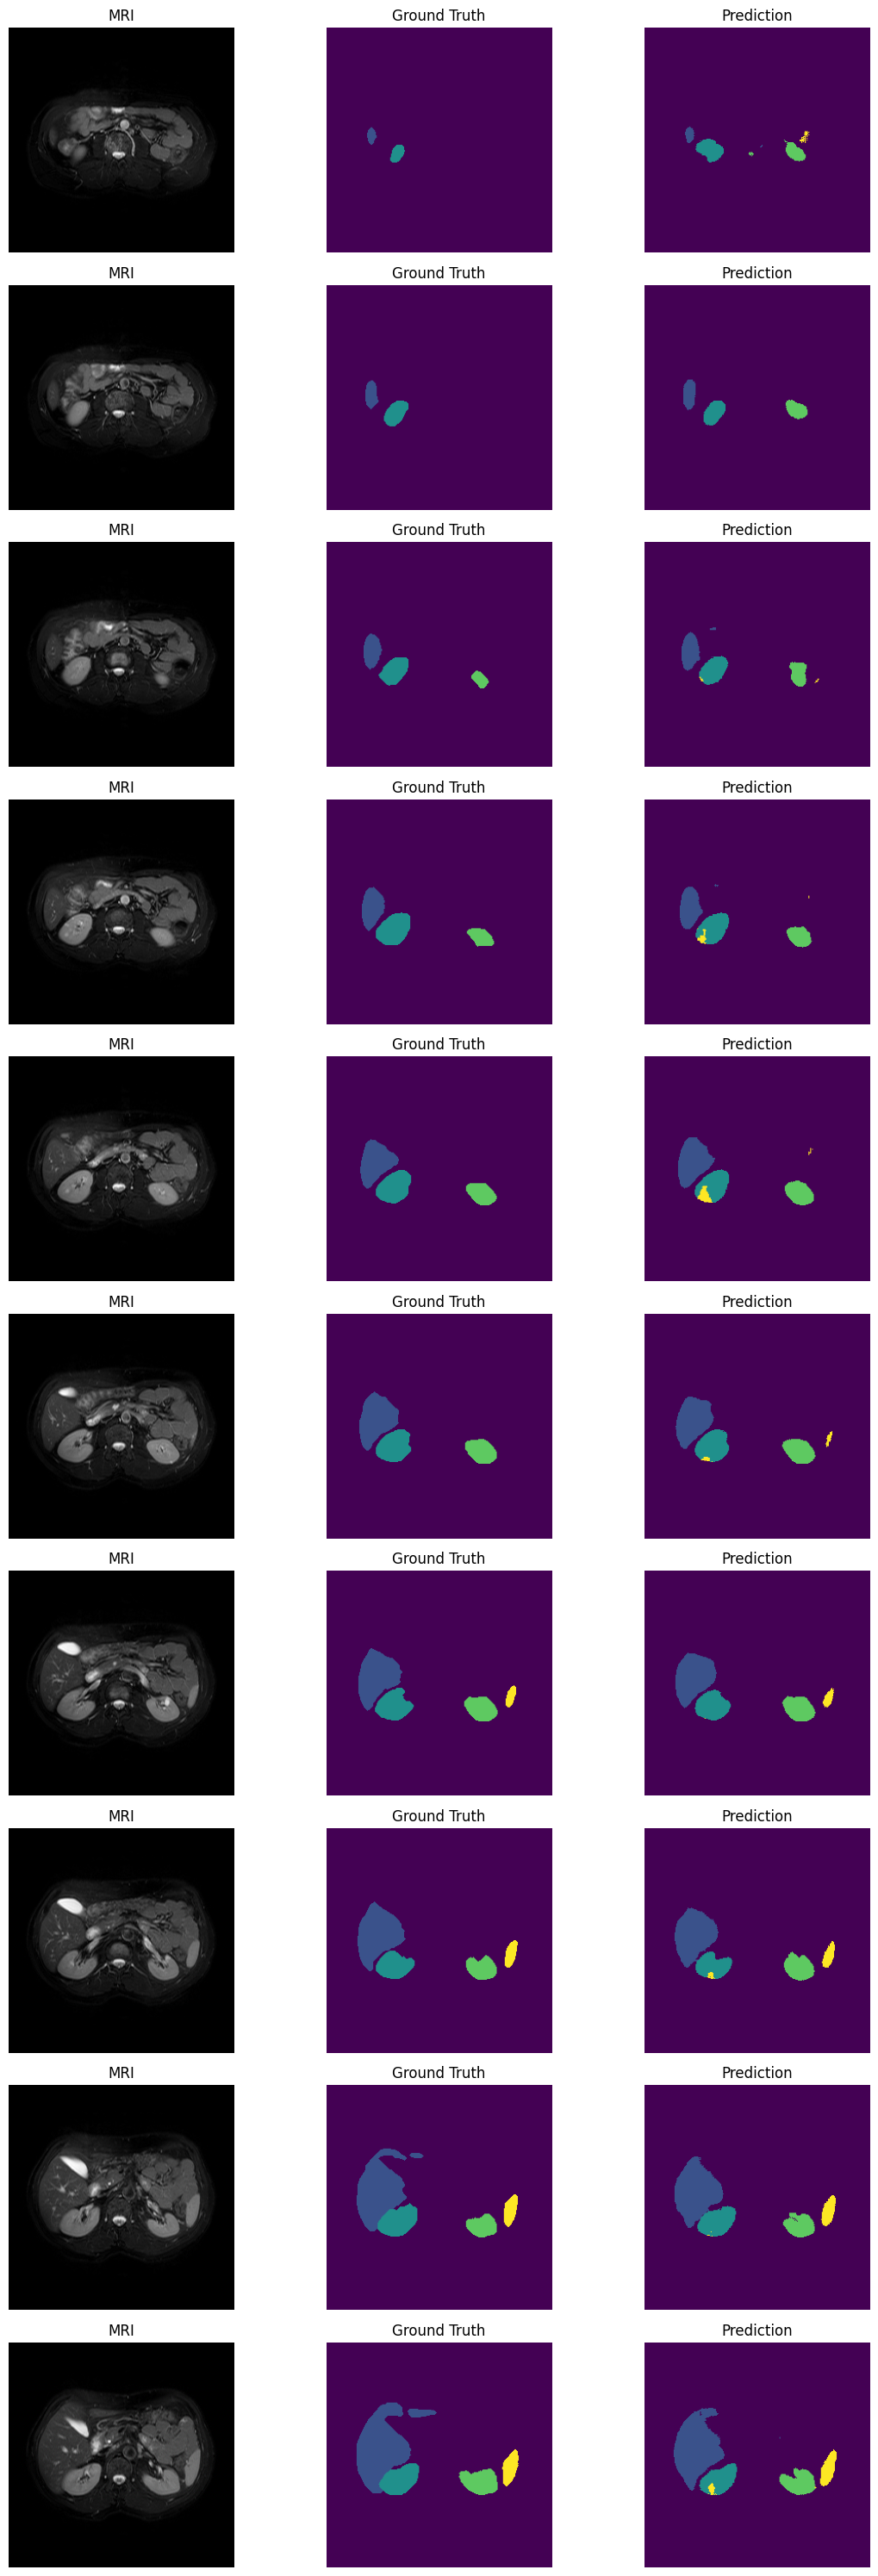

In [ ]:
show_test_predictions(model, test_loader, num_samples=10)


Class 0: Background

Class 1: liver

Class 2: Left Kidney

Class 3: Right kidney

Class 4: Spleen

In [ ]:
all_dices = evaluate_model(model, test_loader, NUM_CLASSES)

mean_dice_per_class = np.nanmean(all_dices, axis=0)
std_dice_per_class  = np.nanstd(all_dices, axis=0)

for c in range(NUM_CLASSES):
    print(f"Class {c}: Dice = {mean_dice_per_class[c]:.3f} ± {std_dice_per_class[c]:.3f}")
dice_no_bg = mean_dice_per_class[1:]
print(f"Mean Dice (organs only) = {np.nanmean(dice_no_bg):.3f}")

Class 0: Dice = 0.992 ± 0.006
Class 1: Dice = 0.725 ± 0.320
Class 2: Dice = 0.757 ± 0.328
Class 3: Dice = 0.563 ± 0.437
Class 4: Dice = 0.496 ± 0.434
Mean Dice (organs only) = 0.635


| Modality / Scenario                          | Class 0 (BG)  | Class 1       | Class 2       | Class 3       | Class 4       | **Mean Dice (Organs)** |
| -------------------------------------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ---------------------- |
| **T2SPIR**                                   | 0.992 ± 0.013 | 0.757 ± 0.328 | 0.757 ± 0.328 |  0.563 ± 0.437 | 0.496 ± 0.434 | **0.635**              |
| **T1DUAL In-Phase**                          | 0.994 ± 0.005 | 0.847 ± 0.193 | 0.642 ± 0.368 | 0.529 ± 0.414 | 0.508 ± 0.420 | **0.632**              |
| **T1DUAL Out-Phase**                         | 0.994 ± 0.004 | 0.838 ± 0.199 | 0.714 ± 0.274 | 0.680 ± 0.358 | 0.552 ± 0.378 | **0.696**              |
| **T1DUAL In + Out (stacked)**                | 0.994 ± 0.003 | 0.787 ± 0.272 | 0.621 ± 0.404 | 0.632 ± 0.387 | 0.477 ± 0.418 | **0.629**              |
| **All Modalities (T2SPIR + T1 In + T1 Out)** | 0.993 ± 0.005 | 0.766 ± 0.287 | 0.681 ± 0.372 | 0.582 ± 0.402 | 0.484 ± 0.426 | **0.628**              |


## U-Net Model

Compared to the MONAI implementation, this custom U-Net reimplements the same encoder–decoder structure, allowing greater architectural control and a clearer understanding of each component’s role.

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(self.pool(x))


class Up(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = DoubleConv(in_ch + skip_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)

        # Align skip connection spatial dimensions with upsampled x
        if x.shape[-2:] != skip.shape[-2:]:
            skip = F.interpolate(skip, size=x.shape[-2:], mode='bilinear', align_corners=False)

        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


In [ ]:
class UNet2D(nn.Module):
    def __init__(self, in_channels=1, num_classes=5, base=32):
        super().__init__()

        # Encoder
        self.inc = DoubleConv(in_channels, base)       # 256
        self.d1  = Down(base, base*2)                  # 128
        self.d2  = Down(base*2, base*4)                # 64
        self.d3  = Down(base*4, base*8)                # 32

        # Bottleneck
        self.bottleneck = DoubleConv(base*8, base*16)  # 32

        # Decoder (3 UP SEULEMENT)
        self.u3 = Up(base*16, base*8, base*8)          # 64
        self.u2 = Up(base*8,  base*4, base*4)          # 128
        self.u1 = Up(base*4,  base*2, base*2)          # 256

        # Final projection
        self.outc = nn.Conv2d(base*2, num_classes, kernel_size=1)

    def forward(self, x):
        x0 = self.inc(x)     # 256
        x1 = self.d1(x0)    # 128
        x2 = self.d2(x1)    # 64
        x3 = self.d3(x2)    # 32

        xb = self.bottleneck(x3)

        x = self.u3(xb, x3)
        x = self.u2(x,  x2)
        x = self.u1(x,  x1)

        return self.outc(x)


In [ ]:
x = torch.randn(1, 1, 256, 256).to(DEVICE)
model = UNet2D().to(DEVICE)
y = model(x)
print(y.shape)


torch.Size([1, 5, 256, 256])


### Training U-Net

We train the model using two approaches: a single fixed train–validation split as a baseline, and K-fold cross-validation for a more robust assessment of generalization. Comparing both helps evaluate stability and performance across different data splits.

#### Training U-Net(without K-fold)

Epoch 01/20 | train_loss=1.6139 | val_loss=1.2908 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.979 0.498 0.244 0.344 0.507]


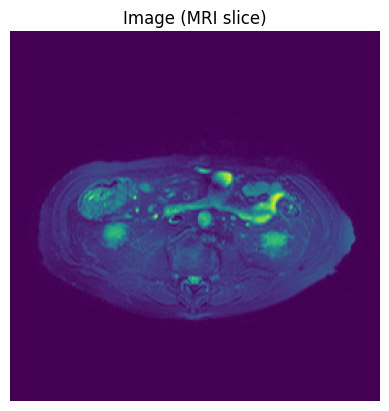

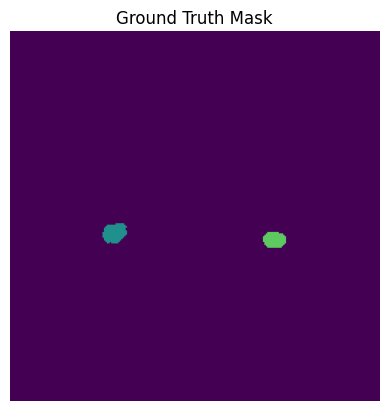

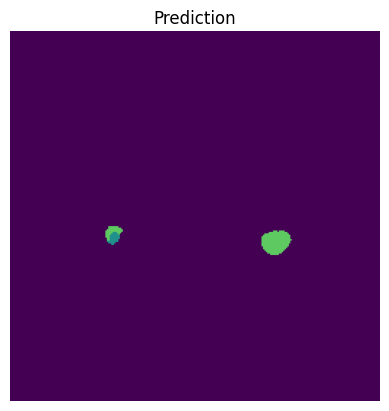

Epoch 02/20 | train_loss=1.1324 | val_loss=1.1409 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.973 0.629 0.49  0.466 0.254]
Epoch 03/20 | train_loss=0.8709 | val_loss=0.7636 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.989 0.784 0.851 0.563 0.648]
Epoch 04/20 | train_loss=0.7214 | val_loss=0.7031 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.987 0.653 0.817 0.673 0.841]
Epoch 05/20 | train_loss=0.6517 | val_loss=0.6269 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.992 0.792 0.826 0.519 0.776]
Epoch 06/20 | train_loss=0.6035 | val_loss=0.5828 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.993 0.747 0.922 0.879 0.74 ]
Epoch 07/20 | train_loss=0.5646 | val_loss=0.6132 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.991 0.833 0.931 0.866 0.635]
Epoch 08/20 | train_loss=0.5511 | val_loss=0.5649 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.993 0.812 0.843 0.731 0.676]
Epoch 09/20 | train_loss=0.5332 | val_loss=0.6049 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.991 0.754 0.895 0.704 0.438]
Epoch 10/20 | train_loss=0.5232 | val_loss=0.5640 | Dice (bg,liv

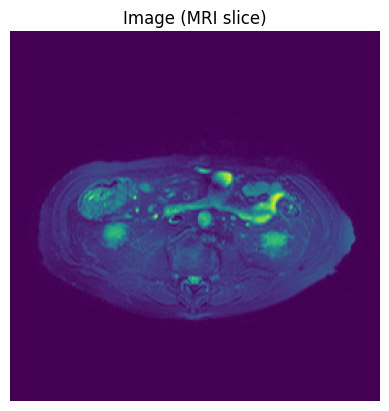

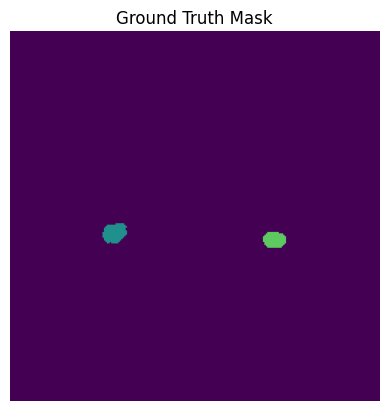

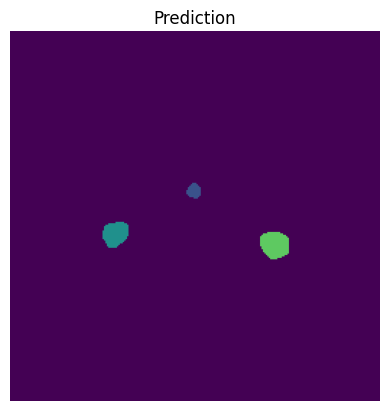

Saved model.


In [ ]:
model = UNet2D(in_channels=1, num_classes=NUM_CLASSES, base=32).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
val_losses = []
val_dices = []

for epoch in range(1, MAX_EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer)
    va_loss, va_dice = validate(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_dices.append(va_dice)

    # Dice organs
    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"Dice (bg,liver,Rkid,Lkid,spleen)={np.round(va_dice, 3)}")

    if epoch in [1, MAX_EPOCHS]:
        show_prediction(model, val_loader)

# Optional saving
torch.save(model.state_dict(), "unet_T2SPIR.pth")
print("Saved model.")


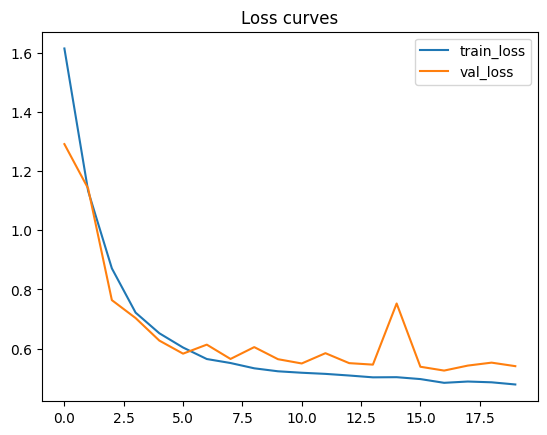

In [ ]:
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.title("Loss curves")
plt.show()


Evaluation on test

In [ ]:
model_unet_T2SPIR = UNet2D(in_channels=1, num_classes=NUM_CLASSES, base=32).to(DEVICE)
model_unet_T2SPIR.load_state_dict(torch.load("unet_T2SPIR.pth", map_location=DEVICE))


<All keys matched successfully>

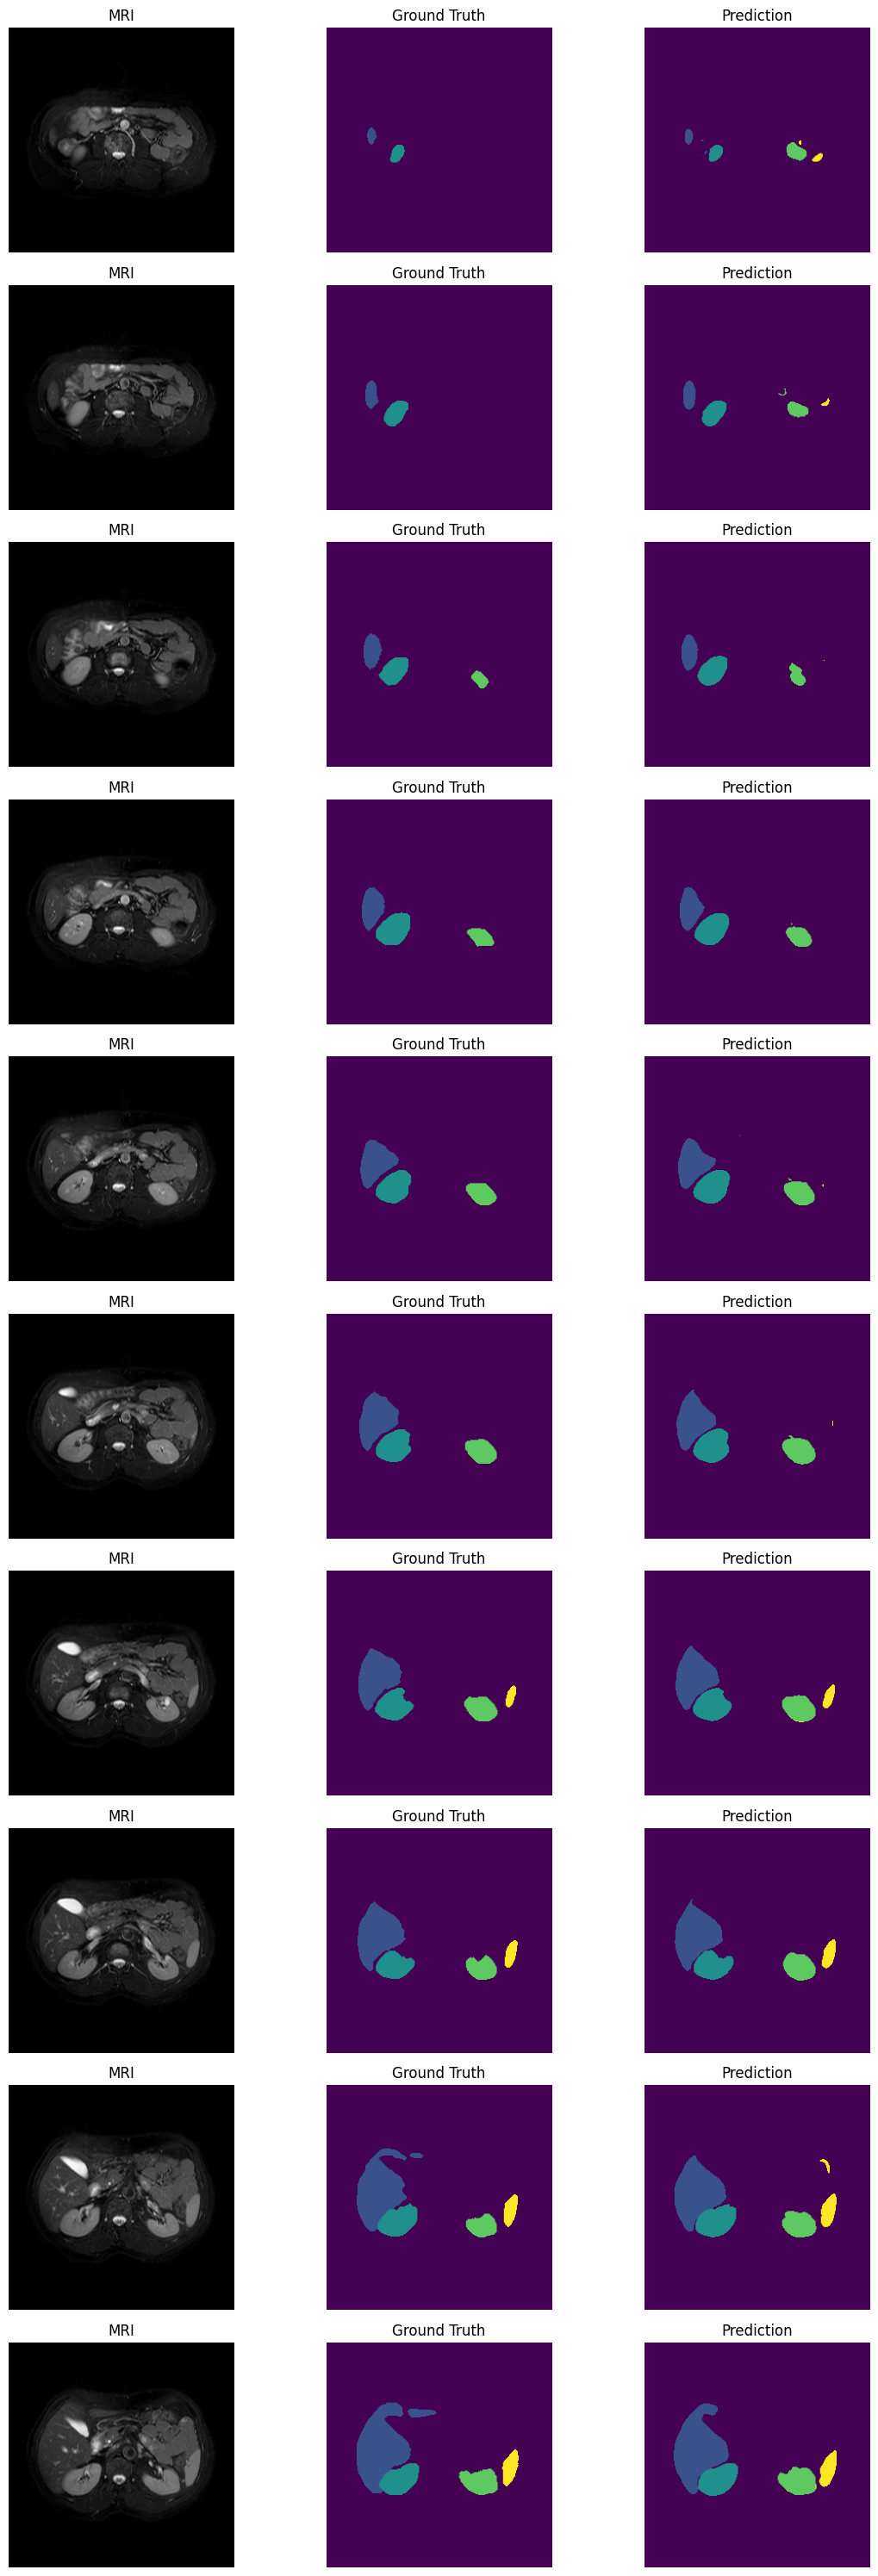

In [ ]:
show_test_predictions(model_unet_T2SPIR, test_loader, num_samples=10)


In [ ]:
#save_test_predictions(
#    model,
#    test_loader,
#    save_dir="test_comparisons",
#    max_samples=None   # ou un nombre, ex: 50
#)


In [ ]:
import shutil
from google.colab import files

output_filename = 'test_comparisons_archive'
dir_to_zip = 'test_comparisons'

# Create a zip archive of the directory
#shutil.make_archive(output_filename, 'zip', dir_to_zip)

print(f"'{dir_to_zip}' has been zipped into '{output_filename}.zip'")

# Offer the file for download
#files.download(f'{output_filename}.zip')

In [ ]:
all_dices = evaluate_model(model, test_loader, NUM_CLASSES)

mean_dice_per_class = np.nanmean(all_dices, axis=0)
std_dice_per_class  = np.nanstd(all_dices, axis=0)

for c in range(NUM_CLASSES):
    print(f"Class {c}: Dice = {mean_dice_per_class[c]:.3f} ± {std_dice_per_class[c]:.3f}")
dice_no_bg = mean_dice_per_class[1:]
print(f"Mean Dice (organs only) = {np.nanmean(dice_no_bg):.3f}")


Class 0: Dice = 0.995 ± 0.004
Class 1: Dice = 0.826 ± 0.270
Class 2: Dice = 0.850 ± 0.270
Class 3: Dice = 0.748 ± 0.327
Class 4: Dice = 0.642 ± 0.409
Mean Dice (organs only) = 0.767


#### Fixed Test Set + K-Fold Cross-Validation on the Training Set


In [ ]:
all_patients= ['1', '10', '13', '15', '19', '2', '20', '21', '22', '3', '31', '32', '33', '34', '36', '37', '38', '39', '5', '8']
fixed_test = ['1', '39', '37', '10']
trainval_patients = [p for p in all_patients if p not in fixed_test]

print("Train/Val pool:", trainval_patients)
print("Fixed Test:", fixed_test)


Train/Val pool: ['13', '15', '19', '2', '20', '21', '22', '3', '31', '32', '33', '34', '36', '38', '5', '8']
Fixed Test: ['1', '39', '37', '10']


In [ ]:
from sklearn.model_selection import KFold

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)


In [ ]:
fold = 1
fold_summaries = []  # to store val results

for train_index, val_index in kf.split(trainval_patients):

    print(f"\n===== FOLD {fold}/{K} =====")

    train_patients = [trainval_patients[i] for i in train_index]
    val_patients   = [trainval_patients[i] for i in val_index]

    print("Train patients:", train_patients)
    print("Val patients:", val_patients)

    # DATASETS
    train_ds = DICOMSliceDataset(train_patients, base_path=path_data, modality="T2SPIR")
    val_ds   = DICOMSliceDataset(val_patients,   base_path=path_data, modality="T2SPIR")

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False)

    # MODEL
    model = UNet2D(in_channels=1, num_classes=NUM_CLASSES, base=32).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_val_loss = float("inf")
    best_val_dice = -1
    best_model_path = f"unet_fold{fold}.pth"

    # TRAIN LOOP
    for epoch in range(1, MAX_EPOCHS+1):
        train_loss = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_dice = validate(model, val_loader)

        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_dice={val_dice}")

        # Save best model of this fold
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), best_model_path)
            best_val_loss = val_loss
            best_val_dice = val_dice

    print(f"\nBest model for fold {fold} saved as '{best_model_path}'")
    print(f"Final best val_loss = {best_val_loss:.4f}")
    print(f"Final best val_dice = {best_val_dice}")

    fold_summaries.append({
        "fold": fold,
        "val_loss": best_val_loss,
        "val_dice": best_val_dice,
        "model_path": best_model_path
    })

    fold += 1



===== FOLD 1/5 =====
Train patients: ['19', '2', '20', '22', '3', '31', '32', '33', '34', '36', '38', '8']
Val patients: ['13', '15', '21', '5']
Epoch 01 | train_loss=1.7302 | val_loss=1.5403 | val_dice=[0.97664189 0.44983782 0.77243706 0.51548873 0.38604113]
Epoch 02 | train_loss=1.3447 | val_loss=1.2774 | val_dice=[0.98324583 0.40856709 0.79288779 0.62502351 0.59104255]
Epoch 03 | train_loss=1.0857 | val_loss=1.1566 | val_dice=[0.98076169 0.45687917 0.77440114 0.55420206 0.64937607]
Epoch 04 | train_loss=0.9003 | val_loss=1.0318 | val_dice=[0.97836817 0.4859576  0.83319356 0.65213432 0.54845729]
Epoch 05 | train_loss=0.7596 | val_loss=0.9036 | val_dice=[0.98574946 0.58358364 0.92062156 0.84620911 0.67881549]
Epoch 06 | train_loss=0.6135 | val_loss=0.8328 | val_dice=[0.98609848 0.62239201 0.90586403 0.84117212 0.48367522]
Epoch 07 | train_loss=0.5309 | val_loss=0.7915 | val_dice=[0.98615681 0.55749114 0.87133412 0.83116293 0.77963431]
Epoch 08 | train_loss=0.4618 | val_loss=0.7680 | 

In [ ]:
print("\n===== CROSS-VALIDATION SUMMARY =====")
for fs in fold_summaries:
    print(f"Fold {fs['fold']}: val_loss={fs['val_loss']:.4f}, val_dice={fs['val_dice']}, model={fs['model_path']}")



===== CROSS-VALIDATION SUMMARY =====
Fold 1: val_loss=0.7143, val_dice=[0.98782526 0.64814609 0.90769068 0.88099519 0.67026276], model=unet_fold1.pth
Fold 2: val_loss=0.5077, val_dice=[0.99616318 0.84767526 0.92514254 0.86926184 0.67254342], model=unet_fold2.pth
Fold 3: val_loss=0.5199, val_dice=[0.99401265 0.85236905 0.85994192 0.83548756 0.67769282], model=unet_fold3.pth
Fold 4: val_loss=0.5246, val_dice=[0.99344493 0.8110383  0.88295033 0.81407486 0.76033823], model=unet_fold4.pth
Fold 5: val_loss=0.5394, val_dice=[0.994823   0.74984808 0.90279482 0.87291037 0.77731106], model=unet_fold5.pth


In [ ]:
# Identify best fold
best = min(fold_summaries, key=lambda x: x["val_loss"])
best_model_path = best["model_path"]
print("Best model:", best_model_path)

Best model: unet_fold2.pth


In [ ]:
# Test dataset
test_ds = DICOMSliceDataset(
    fixed_test,
    base_path=path_data,
    modality="T2SPIR"
)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)


In [ ]:
# Load best model
best_model = UNet2D(
    in_channels=1,
    num_classes=NUM_CLASSES,
    base=32
).to(DEVICE)

best_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
best_model.eval()
# Evaluate
test_dices = evaluate_model(best_model, test_loader, NUM_CLASSES)
mean_dice_per_class = np.nanmean(test_dices, axis=0)
mean_dice_organs = np.nanmean(mean_dice_per_class[1:])

print("\n===== TEST RESULTS for best model =====")
print("Dice per class:", mean_dice_per_class)
print("Mean Dice (organs only):", mean_dice_organs)



===== TEST RESULTS for best model =====
Dice per class: [0.99489311 0.82004661 0.90788187 0.73373259 0.66261413]
Mean Dice (organs only): 0.7810687991248709


The simple U-Net is strong for large/high-contrast organs but struggles with smaller or low-contrast ones. The mean Dice of 0.78 indicates a solid baseline, and adding advanced techniques like Attention or UNet++ could improve segmentation accuracy, especially for the challenging classes.

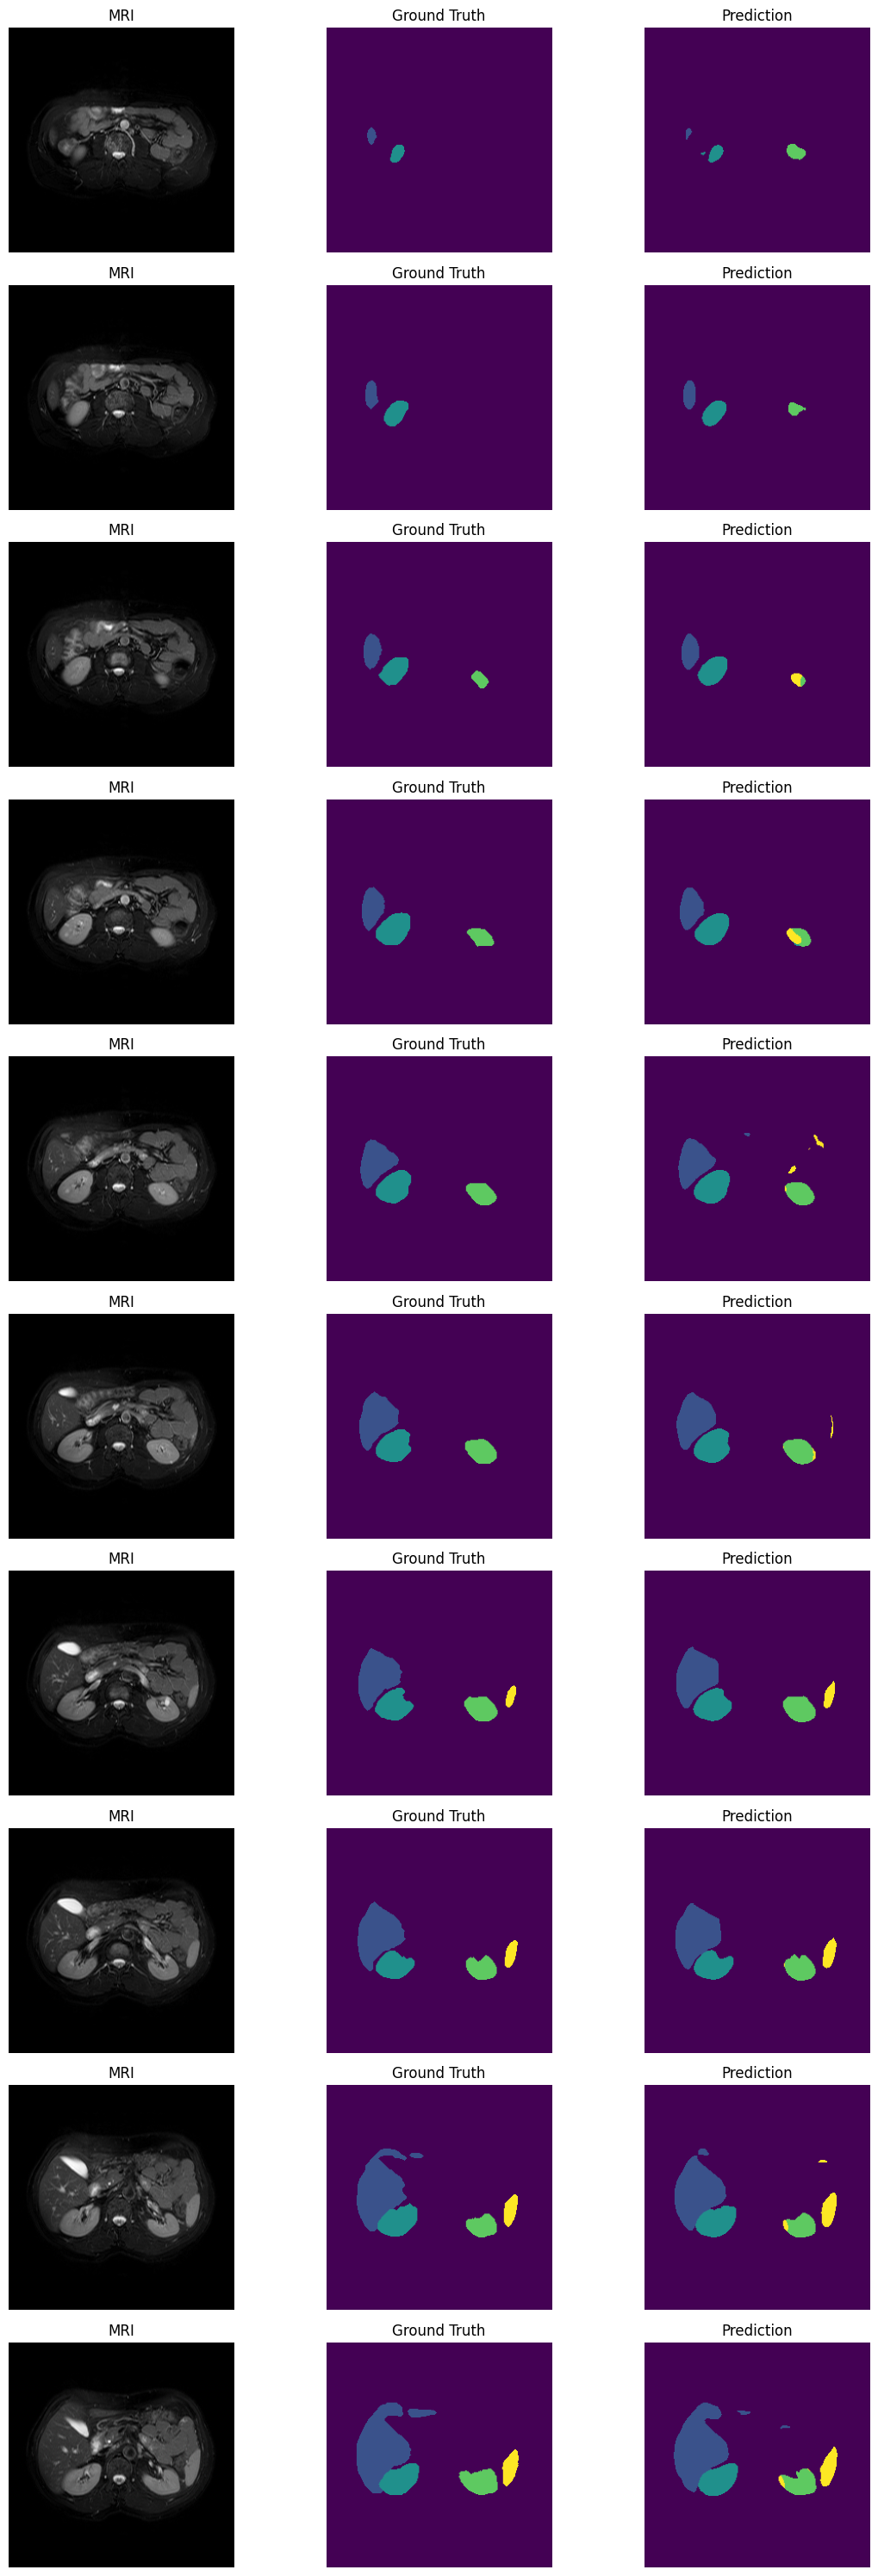

In [ ]:
show_test_predictions(best_model, test_loader, num_samples=10)


## Unet ++

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=1, num_classes=5, base=32, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        nb = [base, base * 2, base * 4, base * 8, base * 16]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Encoder
        self.x0_0 = ConvBlock(in_channels, nb[0])
        self.x1_0 = ConvBlock(nb[0], nb[1])
        self.x2_0 = ConvBlock(nb[1], nb[2])
        self.x3_0 = ConvBlock(nb[2], nb[3])
        self.x4_0 = ConvBlock(nb[3], nb[4])

        # Nested Blocks (Column 1)
        self.x0_1 = ConvBlock(nb[0] + nb[1], nb[0])
        self.x1_1 = ConvBlock(nb[1] + nb[2], nb[1])
        self.x2_1 = ConvBlock(nb[2] + nb[3], nb[2])
        self.x3_1 = ConvBlock(nb[3] + nb[4], nb[3])

        # Nested Blocks (Column 2)
        self.x0_2 = ConvBlock(nb[0]*2 + nb[1], nb[0])
        self.x1_2 = ConvBlock(nb[1]*2 + nb[2], nb[1])
        self.x2_2 = ConvBlock(nb[2]*2 + nb[3], nb[2])

        # Nested Blocks (Column 3)
        self.x0_3 = ConvBlock(nb[0]*3 + nb[1], nb[0])
        self.x1_3 = ConvBlock(nb[1]*3 + nb[2], nb[1])

        # Nested Blocks (Column 4 - The Final Apex)
        self.x0_4 = ConvBlock(nb[0]*4 + nb[1], nb[0])

        # Final Classifiers
        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb[0], num_classes, kernel_size=1)

    def forward(self, x):
        # Column 0 (Encoder)
        x0_0 = self.x0_0(x)
        x1_0 = self.x1_0(self.pool(x0_0))
        x2_0 = self.x2_0(self.pool(x1_0))
        x3_0 = self.x3_0(self.pool(x2_0))
        x4_0 = self.x4_0(self.pool(x3_0))

        # Column 1
        x0_1 = self.x0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x1_1 = self.x1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x2_1 = self.x2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x3_1 = self.x3_1(torch.cat([x3_0, self.up(x4_0)], 1))

        # Column 2
        x0_2 = self.x0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x1_2 = self.x1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x2_2 = self.x2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))

        # Column 3
        x0_3 = self.x0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x1_3 = self.x1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))

        # Column 4
        x0_4 = self.x0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            out1 = self.final1(x0_1)
            out2 = self.final2(x0_2)
            out3 = self.final3(x0_3)
            out4 = self.final4(x0_4)
            return [out1, out2, out3, out4]
        else:
            return self.final(x0_4)

In [ ]:
model = UNetPlusPlus(in_channels=1, num_classes=5, base=32)
model.eval()   # inference mode
import torch

x = torch.randn(1, 1, 256, 256)   # (batch=1, channels=1, H=256, W=256)

with torch.no_grad():
    y = model(x)

print("Input shape :", x.shape)
print("Output shape:", y.shape)

Input shape : torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 5, 256, 256])


Epoch 01/20 | train_loss=1.9389 | val_loss=2.1828 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.981 0.65  0.126 0.151 0.259]
 -> Saved best model


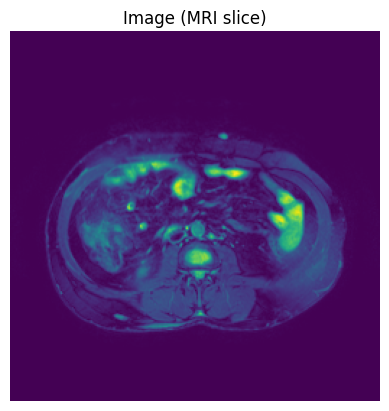

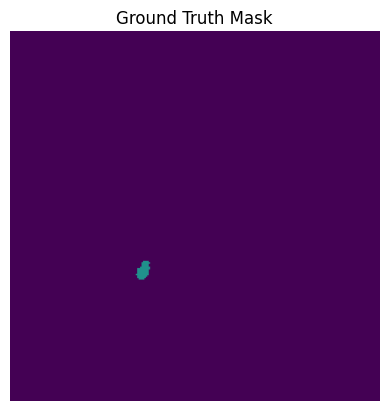

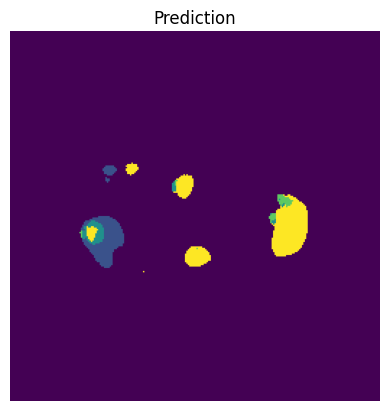

Epoch 02/20 | train_loss=1.6097 | val_loss=1.4992 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.987 0.617 0.679 0.516 0.488]
 -> Saved best model
Epoch 03/20 | train_loss=1.3986 | val_loss=1.3783 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.987 0.746 0.756 0.654 0.327]
 -> Saved best model
Epoch 04/20 | train_loss=1.2199 | val_loss=1.2832 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.968 0.478 0.694 0.601 0.692]
 -> Saved best model
Epoch 05/20 | train_loss=1.0758 | val_loss=1.1040 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.987 0.773 0.811 0.715 0.316]
 -> Saved best model
Epoch 06/20 | train_loss=0.9612 | val_loss=0.9620 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.993 0.809 0.788 0.84  0.499]
 -> Saved best model
Epoch 07/20 | train_loss=0.8563 | val_loss=1.0447 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.985 0.765 0.758 0.349 0.39 ]
Epoch 08/20 | train_loss=0.7611 | val_loss=0.7881 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.994 0.765 0.892 0.817 0.686]
 -> Saved best model
Epoch 09/20 | train_loss=0.6728 | val_loss=0.7704 | Dic

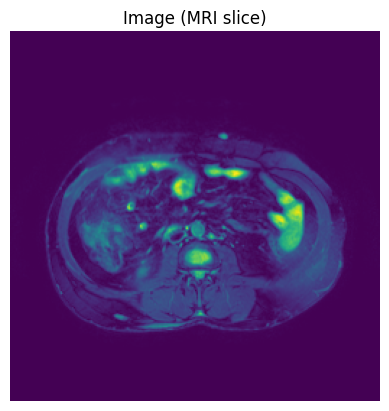

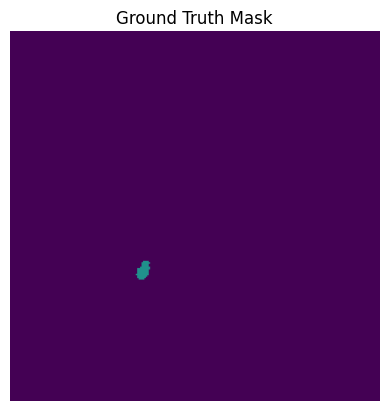

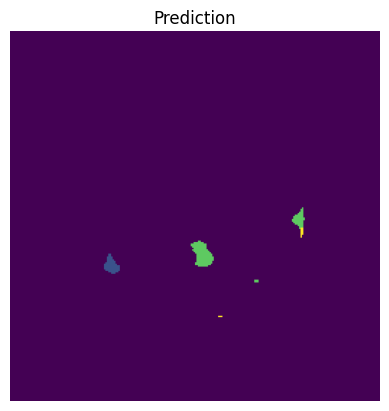

Training complete.


In [ ]:
model = UNetPlusPlus(in_channels=1, num_classes=NUM_CLASSES, base=32).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MAX_EPOCHS=20

train_losses = []
val_losses = []
val_dices = []
best_val_loss = float("inf")

for epoch in range(1, MAX_EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer)
    va_loss, va_dice = validate(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_dices.append(va_dice)

    # Dice organs
    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"Dice (bg,liver,Rkid,Lkid,spleen)={np.round(va_dice, 3)}")

    # Save best model
    if va_loss < best_val_loss:
        torch.save(model.state_dict(), "UNetPlusPlus_best.pth")
        best_val_loss = va_loss
        print(" -> Saved best model")

    if epoch in [1, MAX_EPOCHS]:
        show_prediction(model, val_loader)


print("Training complete.")


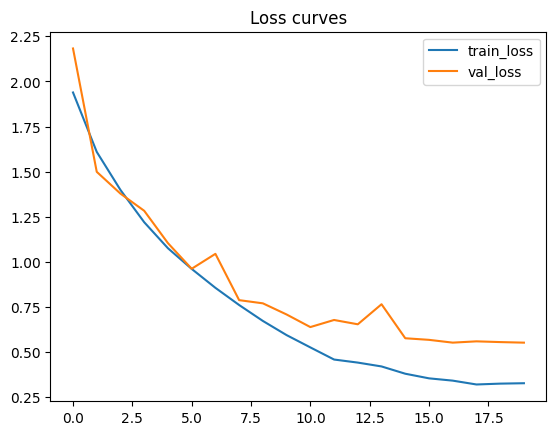

In [ ]:
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.title("Loss curves")
plt.show()


In [ ]:
model_unet_PP = UNetPlusPlus(in_channels=1, num_classes=NUM_CLASSES, base=32).to(DEVICE)
model_unet_PP.load_state_dict(torch.load("UNetPlusPlus_best.pth", map_location=DEVICE))


<All keys matched successfully>

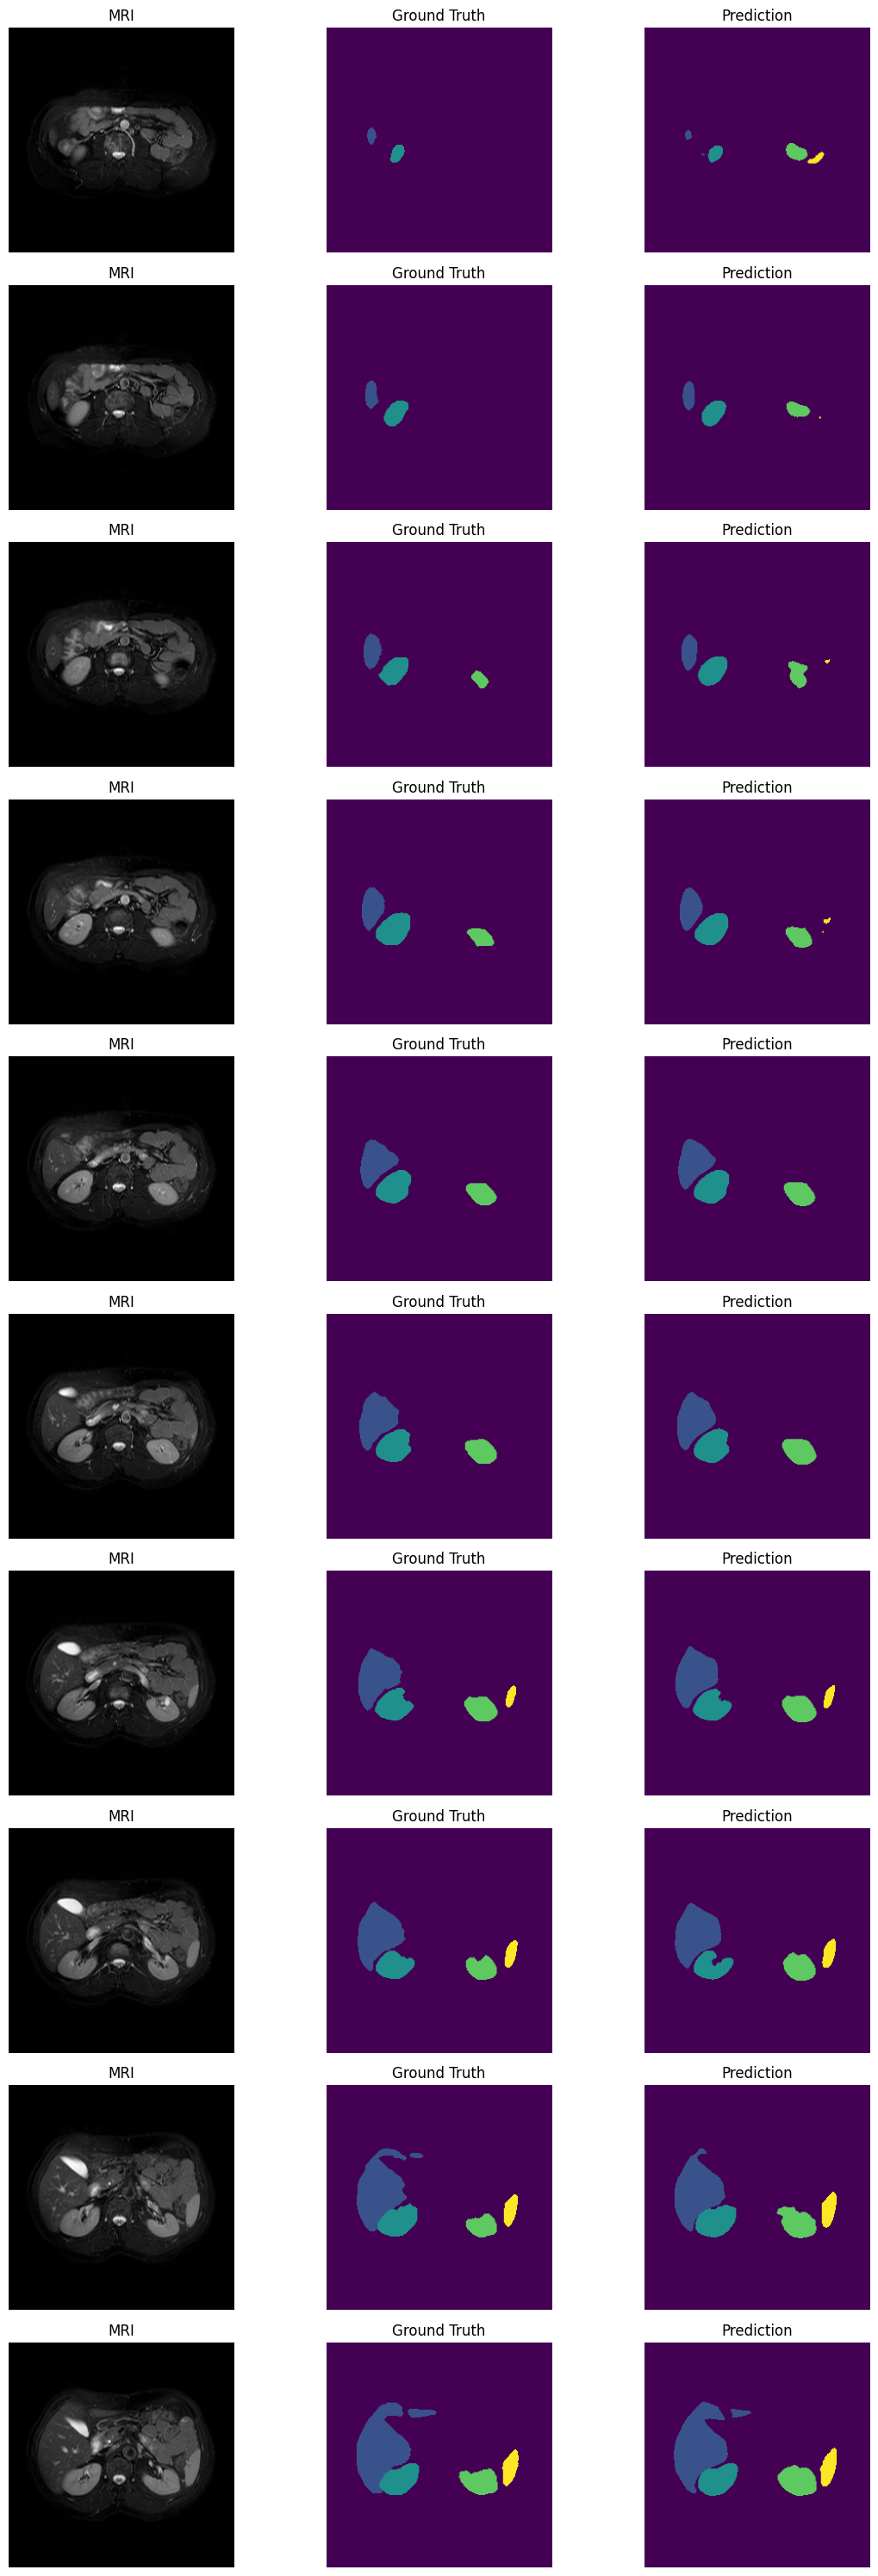

In [ ]:
show_test_predictions(model_unet_PP, test_loader, num_samples=10)


In [ ]:
model_unet_PP.eval()
# Evaluate
test_dices = evaluate_model(model_unet_PP, test_loader, NUM_CLASSES)
mean_dice_per_class = np.nanmean(test_dices, axis=0)
mean_dice_organs = np.nanmean(mean_dice_per_class[1:])

print("\n===== TEST RESULTS unet_PP =====")
print("Dice per class:", mean_dice_per_class)
print("Mean Dice (organs only):", mean_dice_organs)



===== TEST RESULTS unet_PP =====
Dice per class: [0.99488726 0.81995587 0.92085231 0.7827007  0.64138662]
Mean Dice (organs only): 0.791223875439684


## Unet with attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    """
    Filter the features from the skip connection using the decoder's gating signal.
    """
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        # Gating signal (from lower, more semantic layer)
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        # Skip connection signal (from encoder)
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        # Combine and apply activation
        psi = self.relu(g1 + x1)
        # Generate attention coefficients (0 to 1)
        psi = self.psi(psi)
        # Scale the original encoder features
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=5, base=32):
        super().__init__()
        nb = [base, base * 2, base * 4, base * 8, base * 16]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Encoder
        self.enc0 = ConvBlock(in_channels, nb[0])
        self.enc1 = ConvBlock(nb[0], nb[1])
        self.enc2 = ConvBlock(nb[1], nb[2])
        self.enc3 = ConvBlock(nb[2], nb[3])
        self.bottleneck = ConvBlock(nb[3], nb[4])

        # Attention Gates
        self.att3 = AttentionGate(F_g=nb[4], F_l=nb[3], F_int=nb[3]//2)
        self.att2 = AttentionGate(F_g=nb[3], F_l=nb[2], F_int=nb[2]//2)
        self.att1 = AttentionGate(F_g=nb[2], F_l=nb[1], F_int=nb[1]//2)
        self.att0 = AttentionGate(F_g=nb[1], F_l=nb[0], F_int=nb[0]//2)

        # Decoder
        self.dec3 = ConvBlock(nb[4] + nb[3], nb[3])
        self.dec2 = ConvBlock(nb[3] + nb[2], nb[2])
        self.dec1 = ConvBlock(nb[2] + nb[1], nb[1])
        self.dec0 = ConvBlock(nb[1] + nb[0], nb[0])

        self.final = nn.Conv2d(nb[0], num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e0 = self.enc0(x)
        e1 = self.enc1(self.pool(e0))
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Bottleneck
        b = self.bottleneck(self.pool(e3))

        # Decoder with Attention
        # Up 3
        g3 = self.up(b)
        x3 = self.att3(g=g3, x=e3) # Attention Gate
        d3 = self.dec3(torch.cat([g3, x3], dim=1))

        # Up 2
        g2 = self.up(d3)
        x2 = self.att2(g=g2, x=e2)
        d2 = self.dec2(torch.cat([g2, x2], dim=1))

        # Up 1
        g1 = self.up(d2)
        x1 = self.att1(g=g1, x=e1)
        d1 = self.dec1(torch.cat([g1, x1], dim=1))

        # Up 0
        g0 = self.up(d1)
        x0 = self.att0(g=g0, x=e0)
        d0 = self.dec0(torch.cat([g0, x0], dim=1))

        return self.final(d0)

In [ ]:
model = AttentionUNet(in_channels=1, num_classes=5, base=32)
model.eval()   # inference mode
import torch

x = torch.randn(1, 1, 256, 256)   # (batch=1, channels=1, H=256, W=256)

with torch.no_grad():
    y = model(x)

print("Input shape :", x.shape)
print("Output shape:", y.shape)

Epoch 01/20 | train_loss=2.0113 | val_loss=1.8267 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.986 0.59  0.541 0.387 0.127]
 -> Saved best model


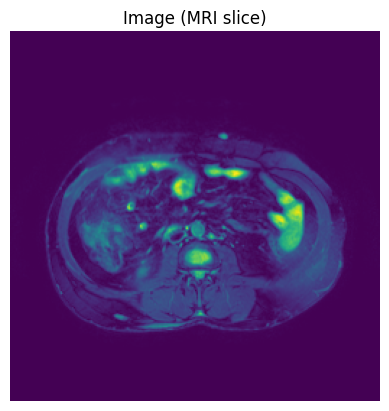

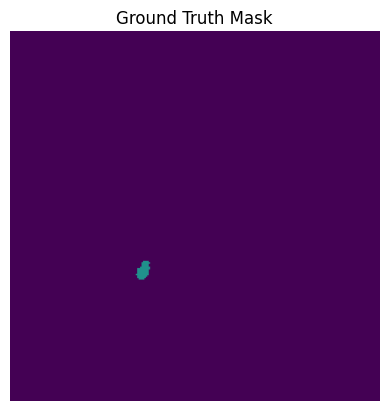

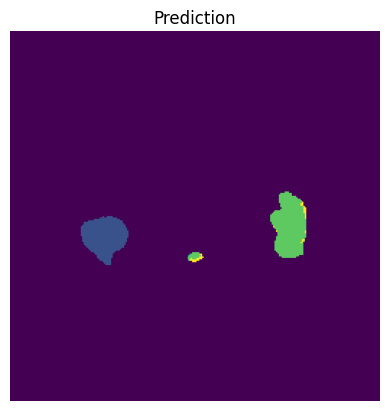

Epoch 02/20 | train_loss=1.6767 | val_loss=1.5441 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.989 0.71  0.753 0.486 0.413]
 -> Saved best model
Epoch 03/20 | train_loss=1.4220 | val_loss=1.3474 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.988 0.695 0.807 0.615 0.362]
 -> Saved best model
Epoch 04/20 | train_loss=1.2184 | val_loss=1.1500 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.994 0.774 0.88  0.834 0.849]
 -> Saved best model
Epoch 05/20 | train_loss=1.0602 | val_loss=1.0450 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.99  0.785 0.708 0.757 0.465]
 -> Saved best model
Epoch 06/20 | train_loss=0.9332 | val_loss=0.9312 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.994 0.82  0.946 0.886 0.781]
 -> Saved best model
Epoch 07/20 | train_loss=0.8336 | val_loss=0.9116 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.986 0.611 0.781 0.797 0.807]
 -> Saved best model
Epoch 08/20 | train_loss=0.7457 | val_loss=0.7737 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.994 0.842 0.901 0.829 0.698]
 -> Saved best model
Epoch 09/20 | train_loss=0.6704 | 

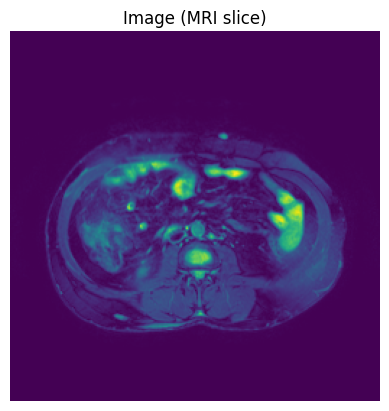

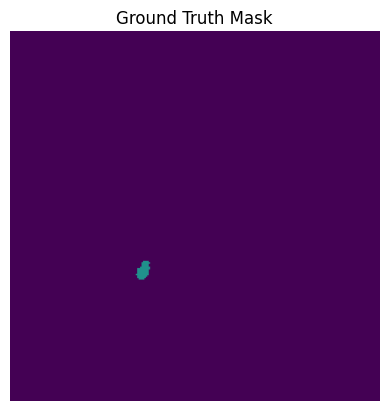

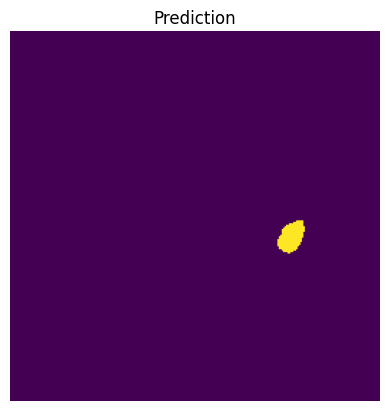

Training complete.


In [ ]:
model = AttentionUNet(in_channels=1, num_classes=NUM_CLASSES, base=32).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MAX_EPOCHS=20

train_losses = []
val_losses = []
val_dices = []
best_val_loss = float("inf")

for epoch in range(1, MAX_EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer)
    va_loss, va_dice = validate(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_dices.append(va_dice)

    # Dice organs
    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"Dice (bg,liver,Rkid,Lkid,spleen)={np.round(va_dice, 3)}")

    # Save best model
    if va_loss < best_val_loss:
        torch.save(model.state_dict(), "AttentionUNet_best.pth")
        best_val_loss = va_loss
        print(" -> Saved best model")

    if epoch in [1, MAX_EPOCHS]:
        show_prediction(model, val_loader)


print("Training complete.")


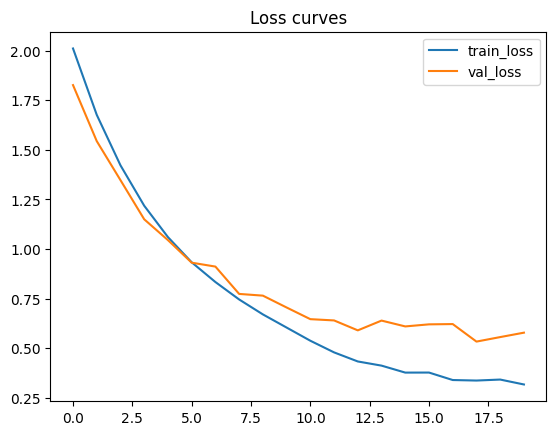

In [ ]:
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.title("Loss curves")
plt.show()


In [ ]:
model_AttentionUNet = AttentionUNet(in_channels=1, num_classes=NUM_CLASSES, base=32).to(DEVICE)
model_AttentionUNet.load_state_dict(torch.load("AttentionUNet_best.pth", map_location=DEVICE))


<All keys matched successfully>

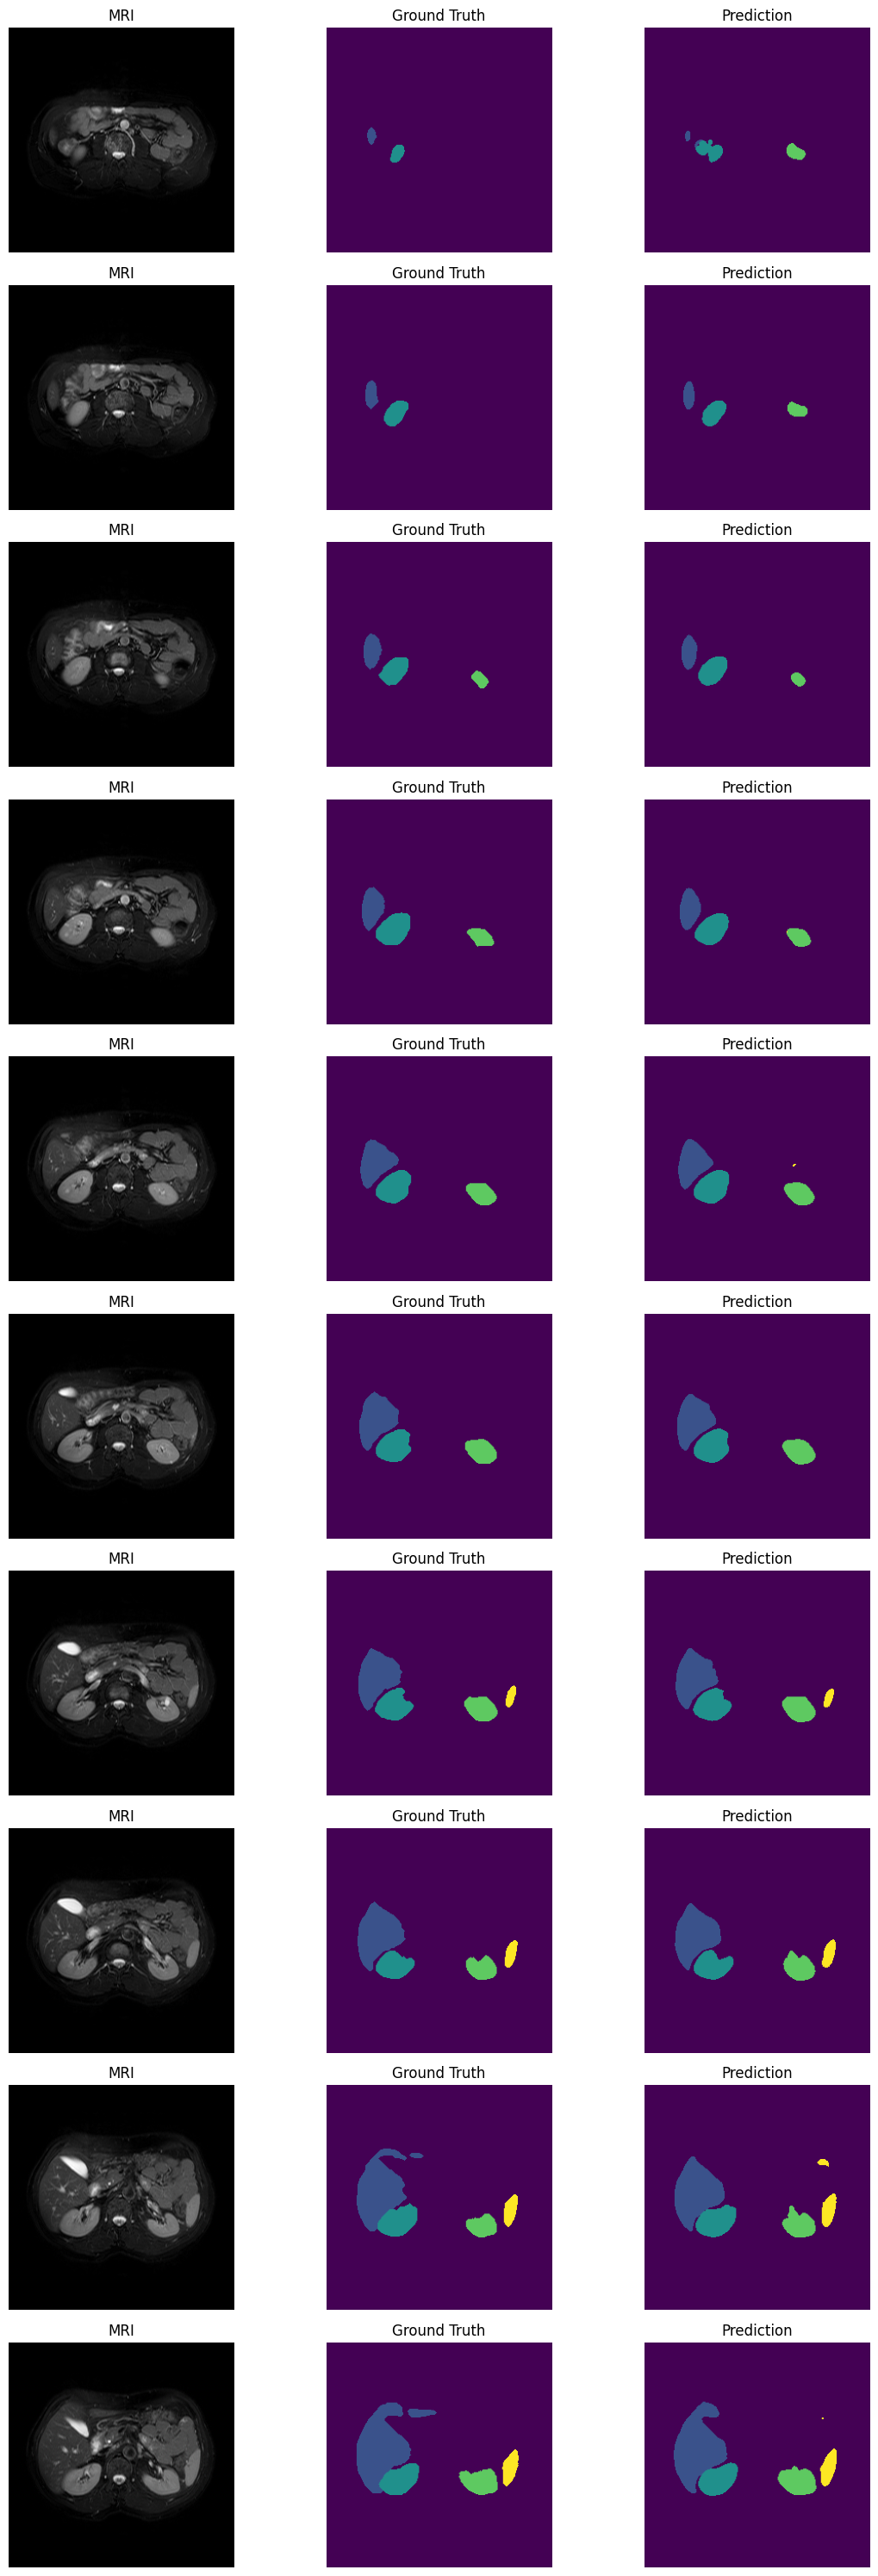

In [ ]:
show_test_predictions(model_AttentionUNet, test_loader, num_samples=10)


In [ ]:
model_AttentionUNet.eval()
# Evaluate
test_dices = evaluate_model(model_AttentionUNet, test_loader, NUM_CLASSES)
mean_dice_per_class = np.nanmean(test_dices, axis=0)
mean_dice_organs = np.nanmean(mean_dice_per_class[1:])

print("\n===== TEST RESULTS AttentionUNet =====")
print("Dice per class:", mean_dice_per_class)
print("Mean Dice (organs only):", mean_dice_organs)



===== TEST RESULTS AttentionUNet =====
Dice per class: [0.99557603 0.86065968 0.9130981  0.82444933 0.69408461]
Mean Dice (organs only): 0.8230729293526743


## Pretrained U-Net with ResNet34 encoder

Finally, a pretrained ResNet34 encoder is integrated into the U-Net architecture to incorporate transfer learning and evaluate its effect on convergence and segmentation performance.

In [ ]:
!pip install segmentation-models-pytorch
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.5 MB/s eta 0:00:00


In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",  # <— TRANSFER LEARNING
    in_channels=1,
    classes=NUM_CLASSES,
)
model = model.to(DEVICE)

# Freeze encoder for fast training
for param in model.encoder.parameters():
    param.requires_grad = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 01/20 | train_loss=1.8961 | val_loss=1.4054 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.975 0.511 0.263 0.163 0.253]
 -> Saved best model


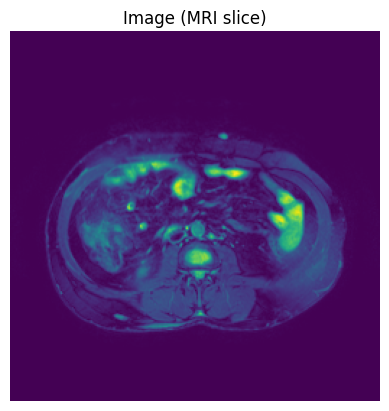

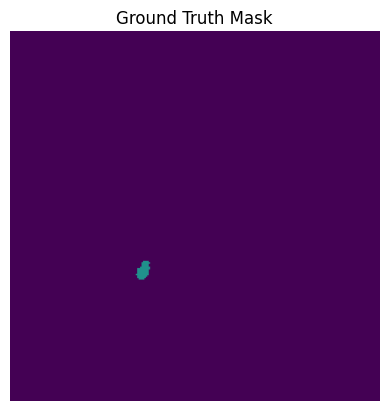

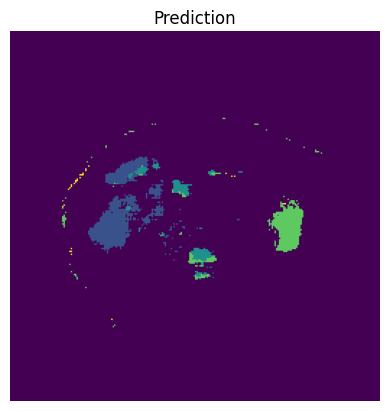

Epoch 02/20 | train_loss=1.1357 | val_loss=1.0334 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.983 0.543 0.524 0.399 0.528]
 -> Saved best model
Epoch 03/20 | train_loss=0.8118 | val_loss=0.8376 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.984 0.659 0.541 0.471 0.465]
 -> Saved best model
Epoch 04/20 | train_loss=0.5916 | val_loss=0.7544 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.987 0.645 0.773 0.766 0.493]
 -> Saved best model
Epoch 05/20 | train_loss=0.4675 | val_loss=0.7179 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.986 0.617 0.826 0.821 0.602]
 -> Saved best model
Epoch 06/20 | train_loss=0.3919 | val_loss=0.6990 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.988 0.692 0.704 0.717 0.431]
 -> Saved best model
Epoch 07/20 | train_loss=0.3729 | val_loss=0.6513 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.99  0.683 0.825 0.822 0.747]
 -> Saved best model
Epoch 08/20 | train_loss=0.3471 | val_loss=0.6670 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.991 0.711 0.697 0.781 0.629]
Epoch 09/20 | train_loss=0.3094 | val_loss=0.6104 | Dic

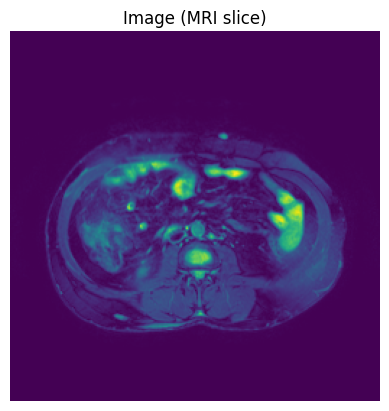

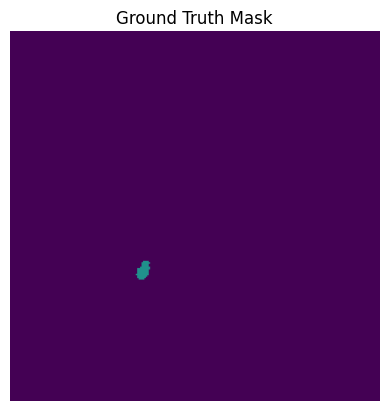

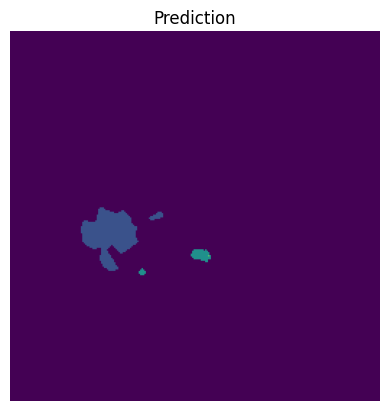

Training complete.


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MAX_EPOCHS=20

train_losses = []
val_losses = []
val_dices = []
best_val_loss = float("inf")

for epoch in range(1, MAX_EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer)
    va_loss, va_dice = validate(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_dices.append(va_dice)

    # Dice organs
    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"Dice (bg,liver,Rkid,Lkid,spleen)={np.round(va_dice, 3)}")

    # Save best model
    if va_loss < best_val_loss:
        torch.save(model.state_dict(), "unet-resnet34_best.pth")
        best_val_loss = va_loss
        print(" -> Saved best model")

    if epoch in [1, MAX_EPOCHS]:
        show_prediction(model, val_loader)


print("Training complete.")


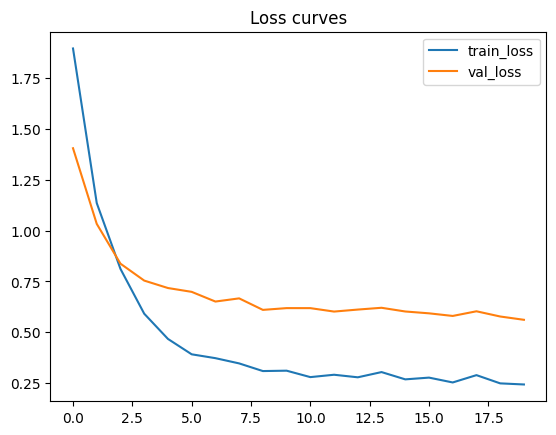

In [ ]:
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.title("Loss curves")
plt.show()


In [ ]:
unet_resnet34_best = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=NUM_CLASSES
).to(DEVICE)

unet_resnet34_best.load_state_dict(torch.load("/content/unet-resnet34_best.pth"))
unet_resnet34_best.eval()

test_dices = evaluate_model(model, test_loader, NUM_CLASSES)
mean_dice_per_class = np.nanmean(test_dices, axis=0)
mean_dice_organs = np.nanmean(mean_dice_per_class[1:])

print("\n===== TEST RESULTS ResNet34-UNet =====")
print("Dice per class:", mean_dice_per_class)

print("Mean Dice (organs only):", mean_dice_organs)



===== TEST RESULTS AttentionUNet =====
Dice per class: [0.99246331 0.76132039 0.86359688 0.74707713 0.68254886]
Mean Dice (organs only): 0.763635814656094


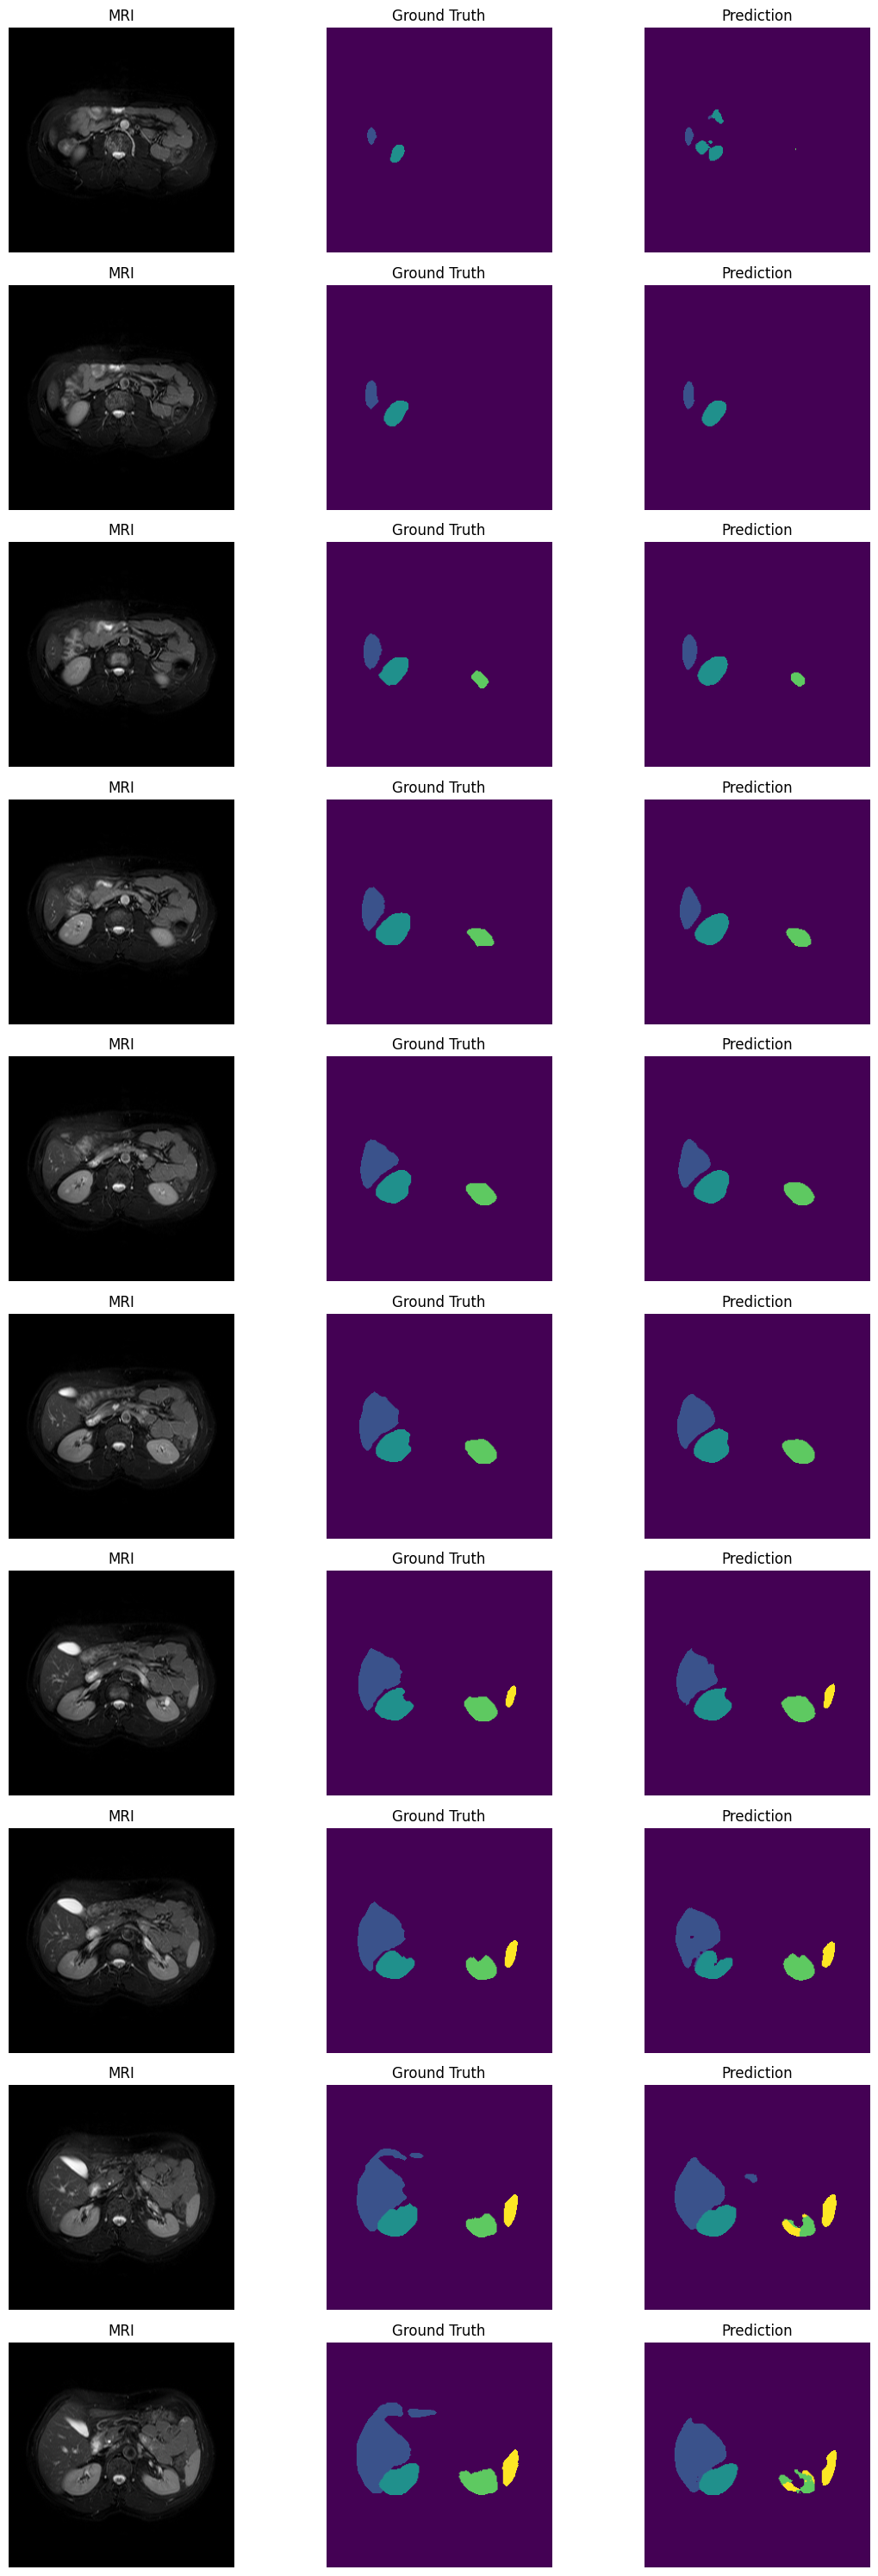

In [ ]:
show_test_predictions(unet_resnet34_best, test_loader, num_samples=10)


## UNet++ + EfficientNet-B0 (pretrained)

As an extension of U-Net++, this model replaces the encoder with a pretrained EfficientNet-B0 backbone and freezes its weights to evaluate the impact of a lightweight transfer-learning encoder on segmentation performance.

In [ ]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",   # ← PRETRAINED
    in_channels=1,                 # MRI is grayscale
    classes=NUM_CLASSES,           # 5 (bg + 4 organs)
).to(DEVICE)

for param in model.encoder.parameters():
    param.requires_grad = False


Epoch 01/20 | train_loss=1.8748 | val_loss=1.6138 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.981 0.483 0.486 0.    0.006]
 -> Saved best model


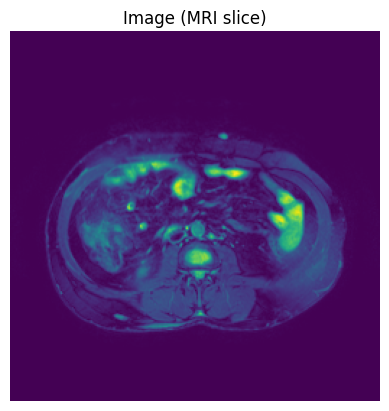

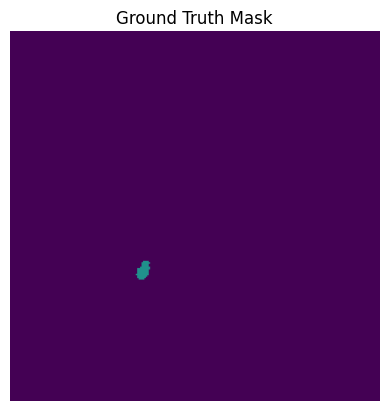

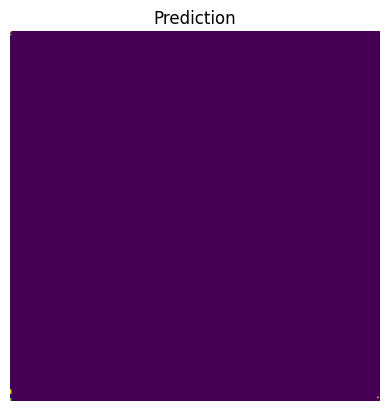

Epoch 02/20 | train_loss=1.0752 | val_loss=1.1614 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.983 0.568 0.453 0.033 0.644]
 -> Saved best model
Epoch 03/20 | train_loss=0.7485 | val_loss=0.8197 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.988 0.651 0.623 0.674 0.399]
 -> Saved best model
Epoch 04/20 | train_loss=0.5363 | val_loss=0.7575 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.988 0.626 0.833 0.636 0.6  ]
 -> Saved best model
Epoch 05/20 | train_loss=0.4385 | val_loss=0.7191 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.987 0.653 0.862 0.716 0.56 ]
 -> Saved best model
Epoch 06/20 | train_loss=0.3795 | val_loss=0.6899 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.987 0.673 0.869 0.832 0.547]
 -> Saved best model
Epoch 07/20 | train_loss=0.3313 | val_loss=0.6230 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.991 0.752 0.891 0.85  0.474]
 -> Saved best model
Epoch 08/20 | train_loss=0.3252 | val_loss=0.5941 | Dice (bg,liver,Rkid,Lkid,spleen)=[0.991 0.757 0.935 0.859 0.678]
 -> Saved best model
Epoch 09/20 | train_loss=0.2957 | 

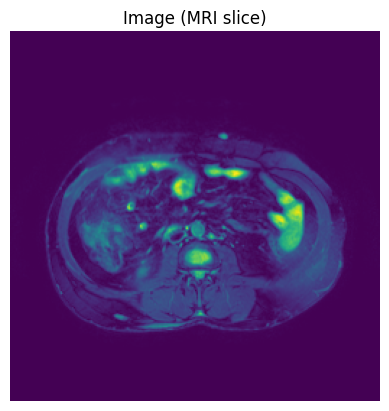

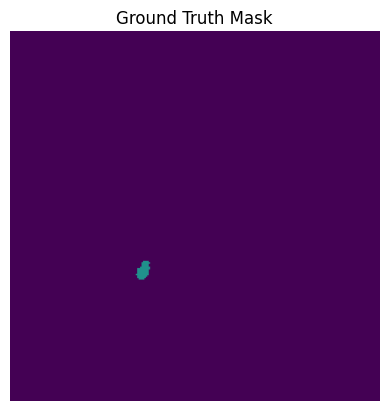

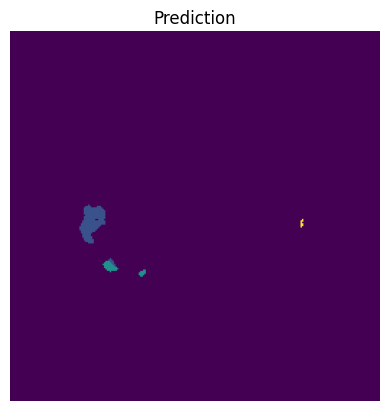

Training complete.


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

MAX_EPOCHS=20

train_losses = []
val_losses = []
val_dices = []
best_val_loss = float("inf")

for epoch in range(1, MAX_EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer)
    va_loss, va_dice = validate(model, val_loader)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_dices.append(va_dice)

    # Dice organs
    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
          f"Dice (bg,liver,Rkid,Lkid,spleen)={np.round(va_dice, 3)}")

    # Save best model
    if va_loss < best_val_loss:
        torch.save(model.state_dict(), "unet-efficientnet_best.pth")
        best_val_loss = va_loss
        print(" -> Saved best model")

    if epoch in [1, MAX_EPOCHS]:
        show_prediction(model, val_loader)


print("Training complete.")


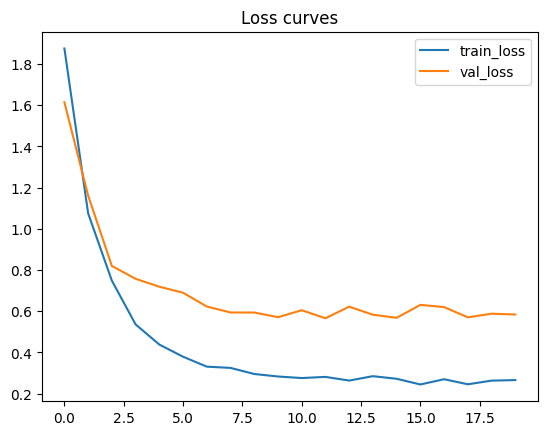

In [ ]:
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.title("Loss curves")
plt.show()


The validation loss >> train loss -> overfitting (the model is failing to learn general patterns and is instead learning the noise or specific details of the training set.)

In [ ]:
unet_efficientnet_best = smp.UnetPlusPlus(
    encoder_name="efficientnet-b0",
    encoder_weights=None,
    in_channels=1,
    classes=NUM_CLASSES
).to(DEVICE)

unet_efficientnet_best.load_state_dict(torch.load("/content/unet-efficientnet_best.pth"))
unet_efficientnet_best.eval()

test_dices = evaluate_model(model, test_loader, NUM_CLASSES)
mean_dice_per_class = np.nanmean(test_dices, axis=0)
mean_dice_organs = np.nanmean(mean_dice_per_class[1:])

print("\n===== TEST RESULTS unet-efficientnet_best =====")
print("Dice per class:", mean_dice_per_class)

print("Mean Dice (organs only):", mean_dice_organs)



===== TEST RESULTS unet-efficientnet_best =====
Dice per class: [0.994721   0.7599484  0.84405858 0.76537292 0.68373927]
Mean Dice (organs only): 0.7632797907348976


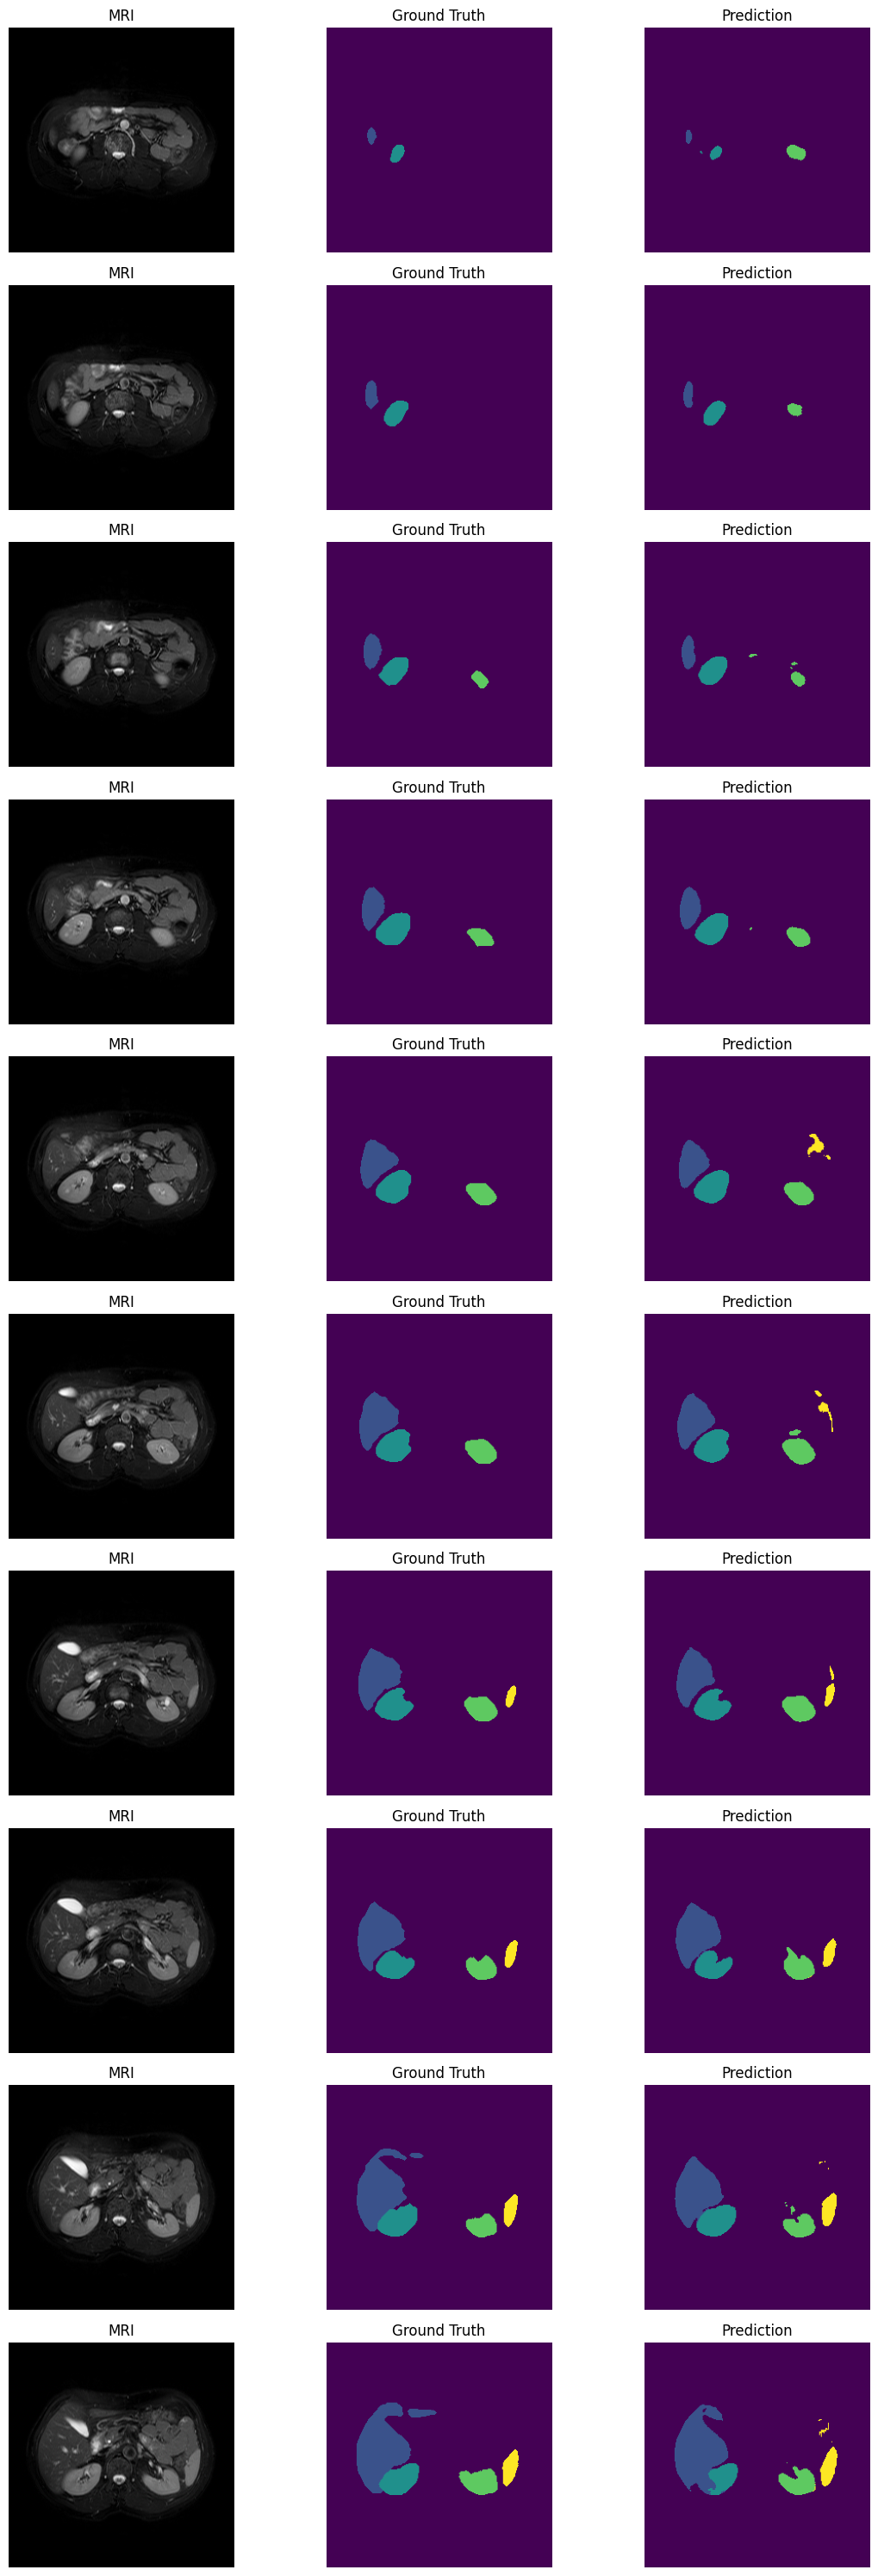

In [ ]:
show_test_predictions(unet_efficientnet_best, test_loader, num_samples=10)
